# Проект: Предсказание коэффициента восстановления золота из руды

**Оглавление**<a id='toc0_'></a>    
- 1. [Подготовка данных](#toc1_)    
  - 1.1. [Загрузка и изучение данных](#toc1_1_)    
  - 1.2. [Проверка расчета эффективности обогащения](#toc1_2_)    
  - 1.3. [Признаки, недоступные в тестовой выборке](#toc1_3_)    
  - 1.4. [Предобработка данных](#toc1_4_)    
  - 1.5. [Вывод по результатам раздела 1](#toc1_5_)    
- 2. [Анализ данных](#toc2_)    
  - 2.1. [Изменение концентрации металлов (Au, Ag, Pb) на различных этапах очистки](#toc2_1_)    
  - 2.2. [Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках](#toc2_2_)    
  - 2.3. [Исследование суммарной концентрации веществ на стадиях технологического процесса](#toc2_3_)    
  - 2.4. [Вывод по результатам раздела 2](#toc2_4_)    
- 3. [Построение, обучение и оценка моделей](#toc3_)    
  - 3.1. [Функция для вычисления итоговой sMAPE.](#toc3_1_)    
  - 3.2. [Подготовка обучающей и тестовой выборок](#toc3_2_)    
  - 3.3. [Обучение моделей и оценка их качества](#toc3_3_)    
    - 3.3.1. [Модель линейная регрессия (LinearRegression)](#toc3_3_1_)    
    - 3.3.2. [Модель линейная регрессия с L2 регуляризацией (Ridge)](#toc3_3_2_)    
    - 3.3.3. [Модель дерево решений (DecisionTreeRegressor)](#toc3_3_3_)    
    - 3.3.4. [Модель случайный лес (RandomForestRegressor)](#toc3_3_4_)    
  - 3.4. [Проверка на тестовой выборке](#toc3_4_)    
  - 3.5. [Вывод по результатам раздела 3](#toc3_5_)    
- 4. [Общий вывод](#toc4_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

**Задание:**

Компанией «Цифра», разрабатывающей решения для эффективной работы промышленных предприятий, предоставлены исходные данные с параметрами добычи и очистки, снятые с технологического процесса восстановления золота из золотосодержащей руды.

Необходимо подготовить прототип модели машинного обучения. Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды и поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

План работы:
1. Подготовка данных.
2. Анализ данных.
3. Построение, обучение и оценка моделей.
4. Общий вывод.

## 1. <a id='toc1_'></a>[Подготовка данных](#toc0_)

### 1.1. <a id='toc1_1_'></a>[Загрузка и изучение данных](#toc0_)

In [1]:
# подключение библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyRegressor
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# константы
PATH = 'D:/Education/Data_Science/Проекты курса DS/Проект_09_сборный_02/datasets/' # путь к файлам на ПК
RST = 12345 # random_state

In [2]:
# функция загрузки и обзора данных
# загружает файл в датасет, отображает его параметры, дубликаты
# на входе - имя файла, на выходе - датасет
def zagr_obz (file):
    # загрузка файла
    try:
        data = pd.read_csv('/datasets/'+file)
    except FileNotFoundError:
        data = pd.read_csv(PATH+file)
    # обзор данных
    print('--------------------------------------------------------\n')
    print('Данные из файла', file, ':\n')
    data.info()
    display(pd.concat([data.head(5), data.sample(5), data.tail(5)]))
    print('Количество полных дубликатов:', data.duplicated().sum())
    print('Количество дубликатов в столбце "date":', data['date'].duplicated().sum())
    print('\nСтатистическая информация:')
    display(data.describe())
    data.hist(bins=100, figsize=(17,88), layout=(22,4))
    plt.show()
    return data

--------------------------------------------------------

Данные из файла gold_recovery_full_new.csv :

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                1

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
14331,2017-11-28 19:59:59,6.341373,9.998652,10.278149,44.355810,73.685514,12.910002,3.880899,12.839110,3.960284,...,17.012890,-499.048522,15.087708,-499.286691,10.988014,-500.836015,8.980312,-500.315199,11.983523,-499.950172
13722,2017-11-02 12:59:59,4.680098,11.971514,8.436943,44.665388,77.059614,7.734739,3.121588,12.339949,1.940350,...,18.018319,-502.501465,15.905211,-500.758760,12.986773,-499.238027,9.986341,-499.133406,13.970464,-501.724136
10989,2017-07-01 09:59:59,4.742301,10.445917,7.716098,45.571347,59.492730,7.258936,2.515827,10.336635,2.362631,...,17.924483,-499.851220,13.088102,-378.978159,17.994841,-500.240598,13.002820,-499.775168,14.992660,-499.836051
7447,2017-01-07 03:59:59,6.180392,11.923463,12.856745,41.332039,71.756395,8.436058,3.456338,7.026122,2.755270,...,16.988609,-497.930121,15.040145,-458.248388,18.645689,-502.286837,8.018678,-455.762519,20.005519,-595.495984
2983,2016-06-13 20:59:59,5.191155,11.017077,8.641909,43.491928,72.044516,7.586934,1.283080,10.111176,2.458738,...,15.940225,-503.633025,14.099489,-432.409420,14.064205,-500.605401,12.024324,-500.585581,25.018007,-502.524785


Количество полных дубликатов: 0
Количество дубликатов в столбце "date": 0

Статистическая информация:


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000,19439.000000,19415.000000,...,19433.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19437.000000,19438.000000
mean,5.168470,9.978895,9.501224,44.076513,67.050208,9.688589,2.705795,10.583728,3.042467,144.624774,...,18.987674,-485.894516,15.010366,-461.078636,15.694452,-488.684065,12.198224,-487.149827,18.959024,-505.436305
std,1.372348,1.669240,2.787537,5.129784,10.125840,2.328642,0.949077,2.868782,0.922808,44.464071,...,5.411058,47.758570,4.890228,67.405524,5.510974,34.533396,5.333024,38.347312,5.550498,37.689057
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.798523,0.000000,-800.836914,-0.372054,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,4.251240,9.137262,7.722820,43.402215,63.299712,8.062878,2.040119,8.938947,2.461138,114.107029,...,14.975734,-500.704892,11.940294,-500.187742,10.988606,-500.458467,8.971105,-500.129462,14.983037,-500.728067
50%,5.066094,10.102433,9.218961,45.011244,68.172738,9.743623,2.748730,10.622456,2.984909,143.232103,...,18.017481,-499.837793,14.971014,-499.459786,15.000036,-499.802605,11.019433,-499.935317,19.960541,-500.048400
75%,5.895527,11.035769,10.947813,46.275313,72.686642,11.134294,3.333216,12.104271,3.571351,175.075656,...,23.012470,-498.249730,19.034162,-400.118106,18.026190,-498.384187,14.019088,-499.436708,24.003170,-499.495378
max,16.001945,17.031899,19.615720,52.756638,100.000000,19.552149,5.804178,22.317730,8.245022,265.983123,...,30.115735,-245.239184,31.269706,-6.506986,43.709931,-244.483566,27.926001,-137.740004,32.188906,-104.427459


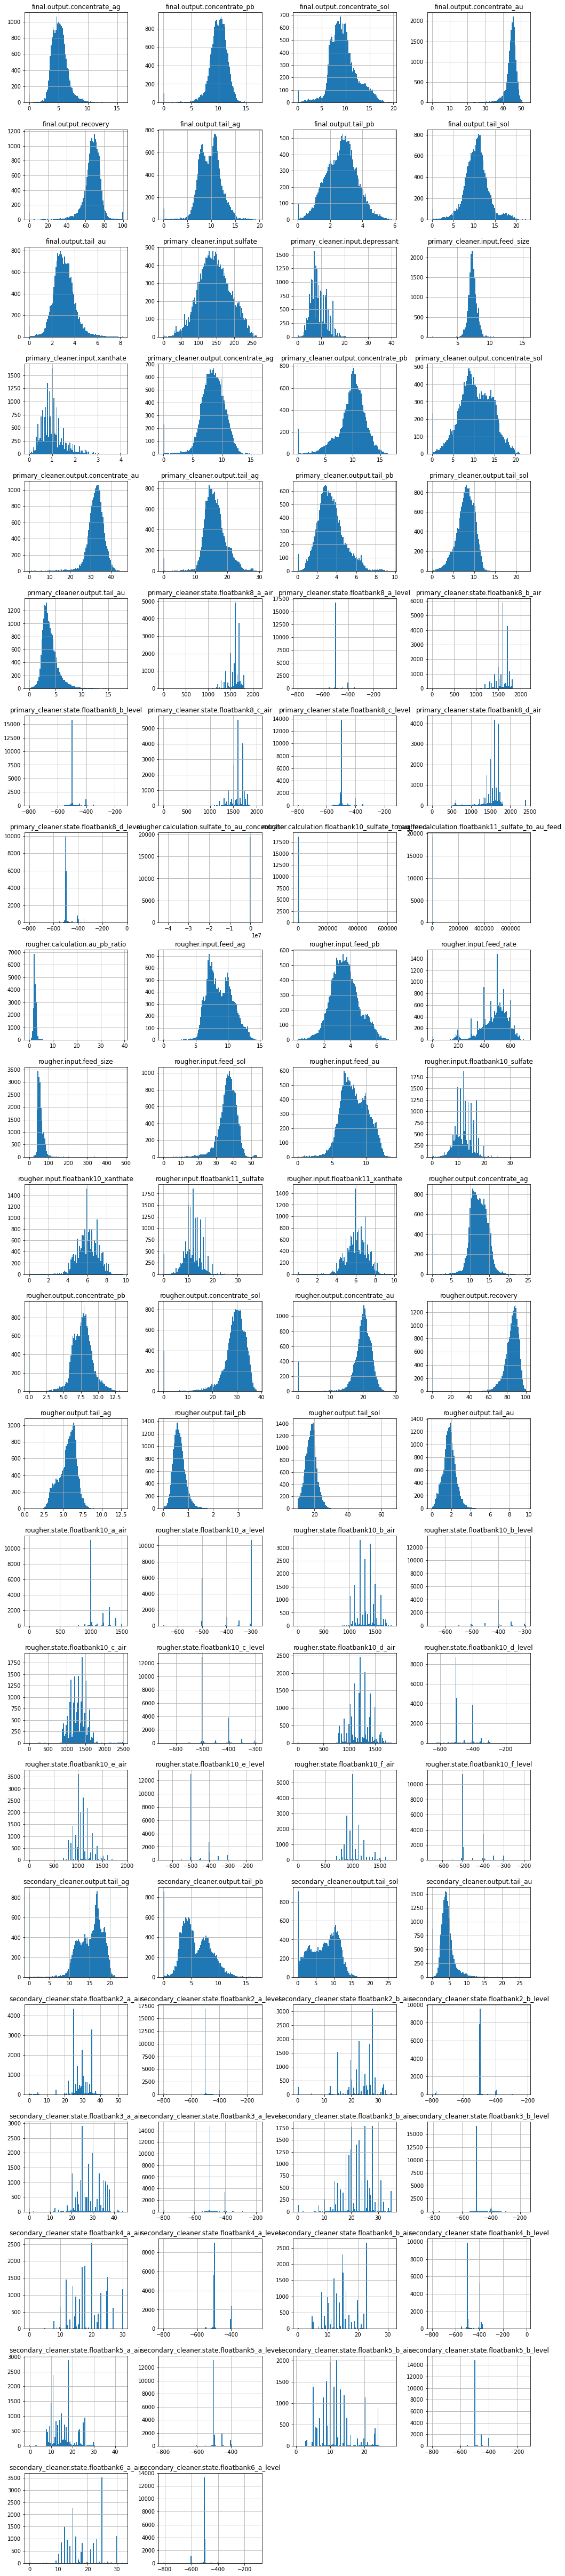

--------------------------------------------------------

Данные из файла gold_recovery_train_new.csv :

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
3715,2016-07-20 06:59:59,7.905118,9.218276,14.829943,41.168856,68.354276,10.307442,2.228927,13.533867,3.690478,...,14.932977,-400.543732,4.969964,-400.597907,9.986301,-398.688685,4.903480,-399.840747,23.033376,-499.753554
13247,2018-06-30 18:59:59,4.285103,15.160977,6.587767,40.031309,72.712568,9.540767,3.411264,8.372278,1.888141,...,30.004360,-501.053369,23.105185,-499.902891,20.006347,-501.476671,14.985481,-500.313304,17.975731,-506.277240
13816,2018-08-01 21:59:59,3.466749,7.556961,17.859817,45.519681,69.491266,15.990799,3.831213,10.331550,3.028136,...,21.971222,-502.867281,17.023406,-500.901188,16.983302,-502.055476,12.997203,-500.021491,0.275624,-808.418266
10448,2018-02-17 15:59:59,6.511120,9.281574,10.832506,43.966842,78.046723,10.896422,1.303467,12.964739,2.071888,...,19.939146,-502.123310,14.933814,-500.156898,10.946072,-500.130882,9.009414,-500.363482,10.986848,-504.162880
11166,2018-03-22 17:59:59,4.892949,11.117649,6.878123,46.120557,72.569034,9.272122,1.873727,8.508698,1.926691,...,22.990431,-500.615476,15.040012,-500.314657,30.008454,-500.306786,15.010674,-499.849513,12.993956,-500.400587


Количество полных дубликатов: 0
Количество дубликатов в столбце "date": 0

Статистическая информация:


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14148.000000,14148.000000,13938.000000,14149.000000,14149.000000,14149.000000,14049.000000,14144.000000,14149.000000,14129.000000,...,14143.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14147.000000,14148.000000
mean,5.142034,10.132960,9.202849,44.003792,66.518832,9.607035,2.597298,10.512122,2.918421,133.320659,...,19.985454,-478.696836,15.487065,-460.229416,16.775136,-483.956022,13.064590,-483.966564,19.577539,-506.798480
std,1.369586,1.654930,2.790516,4.905261,10.295402,2.319069,0.971843,3.003617,0.903712,39.431659,...,5.657723,50.736021,5.255655,58.843586,5.831906,37.892788,5.765617,39.207913,5.764417,37.079249
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003112,...,0.000000,-799.709069,0.000000,-799.889113,-0.372054,-797.142475,0.646208,-800.006180,0.195324,-809.398668
25%,4.211620,9.297355,7.484645,43.276111,62.545817,7.997429,1.905973,8.811324,2.368607,107.006651,...,14.990775,-500.628656,11.894558,-500.149000,11.083980,-500.363177,8.994405,-500.105994,14.989304,-500.745104
50%,4.994652,10.297144,8.845462,44.872436,67.432775,9.480270,2.592022,10.514621,2.851025,133.018328,...,20.001789,-499.681450,14.975536,-499.388738,17.932223,-499.702452,11.997547,-499.914556,19.984175,-500.061431
75%,5.859540,11.170603,10.487508,46.166425,72.346428,11.003707,3.241723,11.933009,3.434764,159.825396,...,24.990826,-477.472413,20.059375,-400.039008,21.346550,-487.712108,17.982903,-453.186936,24.991623,-499.536466
max,16.001945,17.031899,18.124851,52.756638,100.000000,19.552149,5.639565,22.317730,8.197408,250.127834,...,30.115735,-245.239184,24.007913,-145.071088,43.709931,-275.073125,27.926001,-157.396071,32.188906,-104.427459


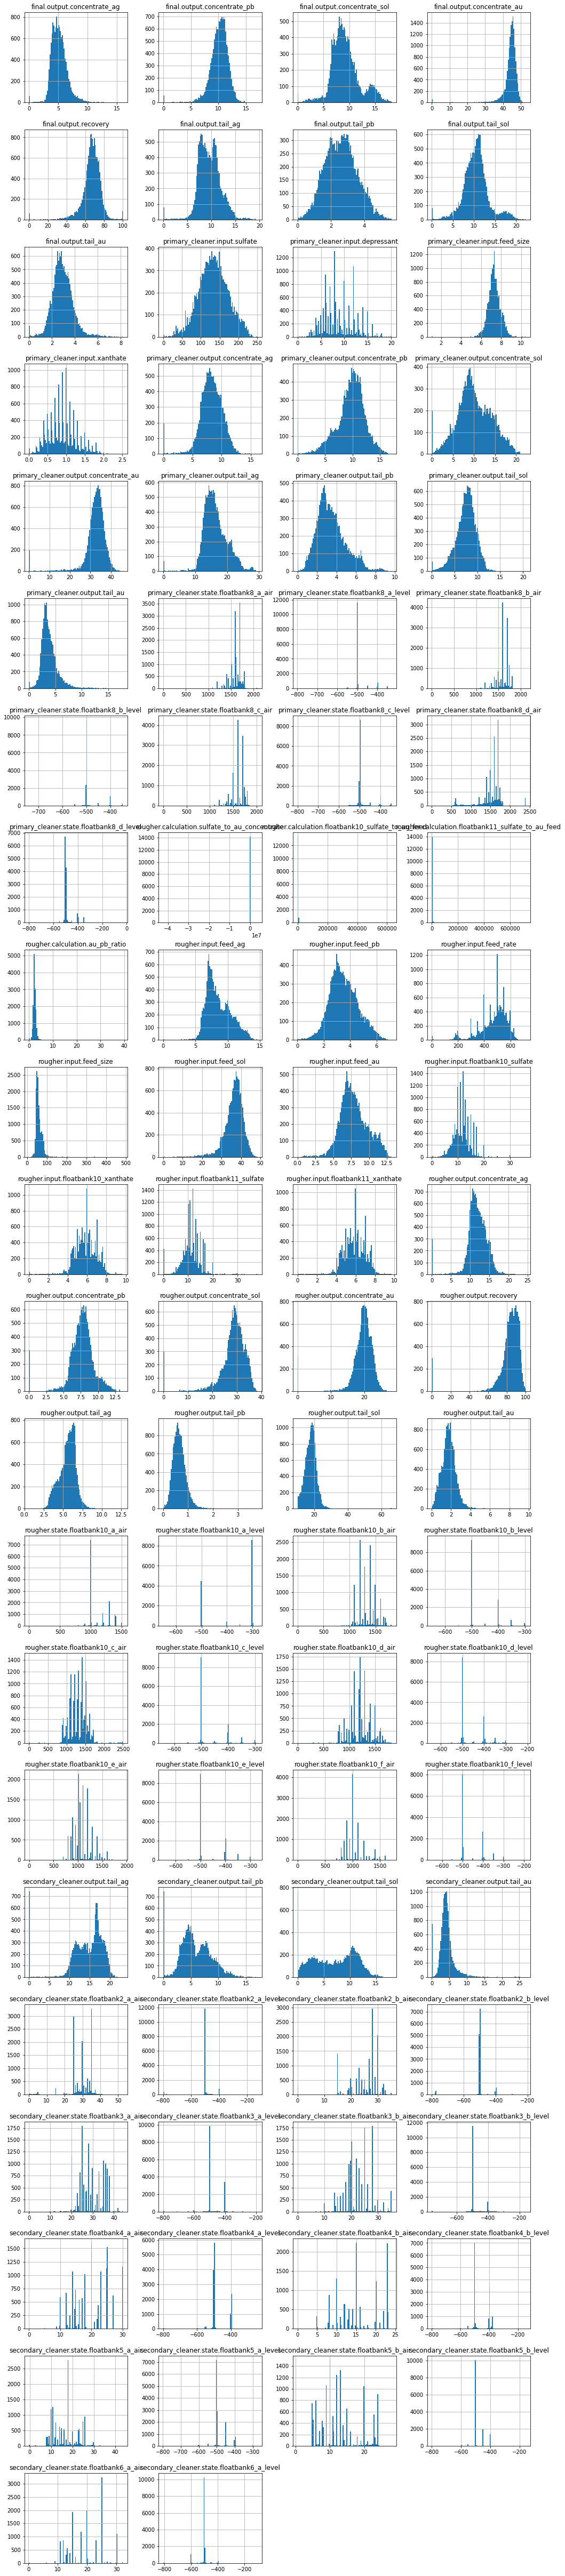

--------------------------------------------------------

Данные из файла gold_recovery_test_new.csv :

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-n

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333
4708,2017-12-05 07:59:59,162.853249,8.943841,7.360000,1.385630,1550.729341,-499.966423,1547.583069,-497.480230,1551.975484,...,18.999722,-502.917796,14.957803,-149.858459,10.934218,-503.208875,8.993438,-500.077692,15.972851,-499.616433
2901,2017-09-16 17:59:59,159.000830,8.470724,6.760000,1.130413,1599.516186,-500.496590,1602.486570,-501.120730,1601.019942,...,12.013838,-502.212300,9.110924,-400.933793,9.091324,-501.302566,6.930534,-500.451519,9.991957,-501.390039
465,2016-09-22 16:59:59,128.874551,5.934176,7.680000,0.827945,1597.554091,-499.593141,1601.183970,-500.061776,1601.925903,...,11.967864,-509.403326,9.956803,-500.475482,10.054859,-499.492720,5.025370,-499.771574,19.993319,-497.479471
5264,2017-12-30 22:59:59,181.604557,15.008554,7.450000,0.892699,1398.672764,-499.960176,1401.429849,-500.920024,1401.232288,...,13.995024,-498.595798,11.954725,-502.011288,7.882318,-500.561757,6.029395,-500.177098,9.010811,-503.193352
1432,2016-11-10 09:59:59,129.892440,4.932869,7.290000,0.901140,1600.961380,-499.899149,1602.120939,-500.317479,1602.372502,...,15.951073,-500.764066,14.034050,-500.075572,15.824675,-499.869721,13.967913,-500.078100,21.978042,-500.435632


Количество полных дубликатов: 0
Количество дубликатов в столбце "date": 0

Статистическая информация:


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5286.000000,5285.000000,5290.000000,5286.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,...,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000
mean,174.839652,8.683596,7.266339,1.383803,1.539494e+03,-497.665883,1.545174e+03,-500.273098,1.527272e+03,-498.330680,...,1.632007e+01,-505.144570,1.373544e+01,-463.349858,12.804186,-501.329122,9.881145,-495.663398,17.304935,-501.793193
std,43.027080,3.072050,0.610219,0.643474,1.167979e+02,19.952431,1.222246e+02,32.968307,1.225380e+02,21.964876,...,3.493583e+00,31.427337,3.430484e+00,86.189107,3.026591,17.951495,2.868205,34.535007,4.536544,39.044215
min,2.566156,0.003839,5.650000,0.004984,5.445860e-32,-795.316337,6.647490e-32,-799.997015,4.033736e-32,-799.960571,...,1.079872e-16,-799.798523,2.489718e-17,-800.836914,0.069227,-797.323986,0.528083,-800.220337,-0.079426,-809.741464
25%,147.121401,6.489555,6.890000,0.907623,1.498936e+03,-500.357298,1.498971e+03,-500.703002,1.473230e+03,-501.018117,...,1.403618e+01,-500.868258,1.202862e+01,-500.323028,10.914838,-500.726841,8.036719,-500.194668,13.997317,-500.690984
50%,177.828489,8.052207,7.250000,1.197610,1.585129e+03,-499.969164,1.595622e+03,-500.028514,1.549595e+03,-500.017711,...,1.700847e+01,-500.115727,1.496486e+01,-499.576513,12.954182,-499.990332,10.004301,-499.990535,16.014935,-500.007126
75%,208.125438,10.027764,7.600000,1.797819,1.602077e+03,-499.568951,1.602324e+03,-499.293257,1.601144e+03,-498.994130,...,1.803862e+01,-499.404224,1.596213e+01,-400.933805,15.097528,-499.283191,11.997467,-499.719913,21.020013,-499.373018
max,265.983123,40.000000,15.500000,4.102454,2.103104e+03,-57.195404,1.813084e+03,-142.527229,1.715054e+03,-150.937035,...,3.005180e+01,-401.565212,3.126971e+01,-6.506986,25.258848,-244.483566,14.086866,-137.740004,26.705889,-123.307487


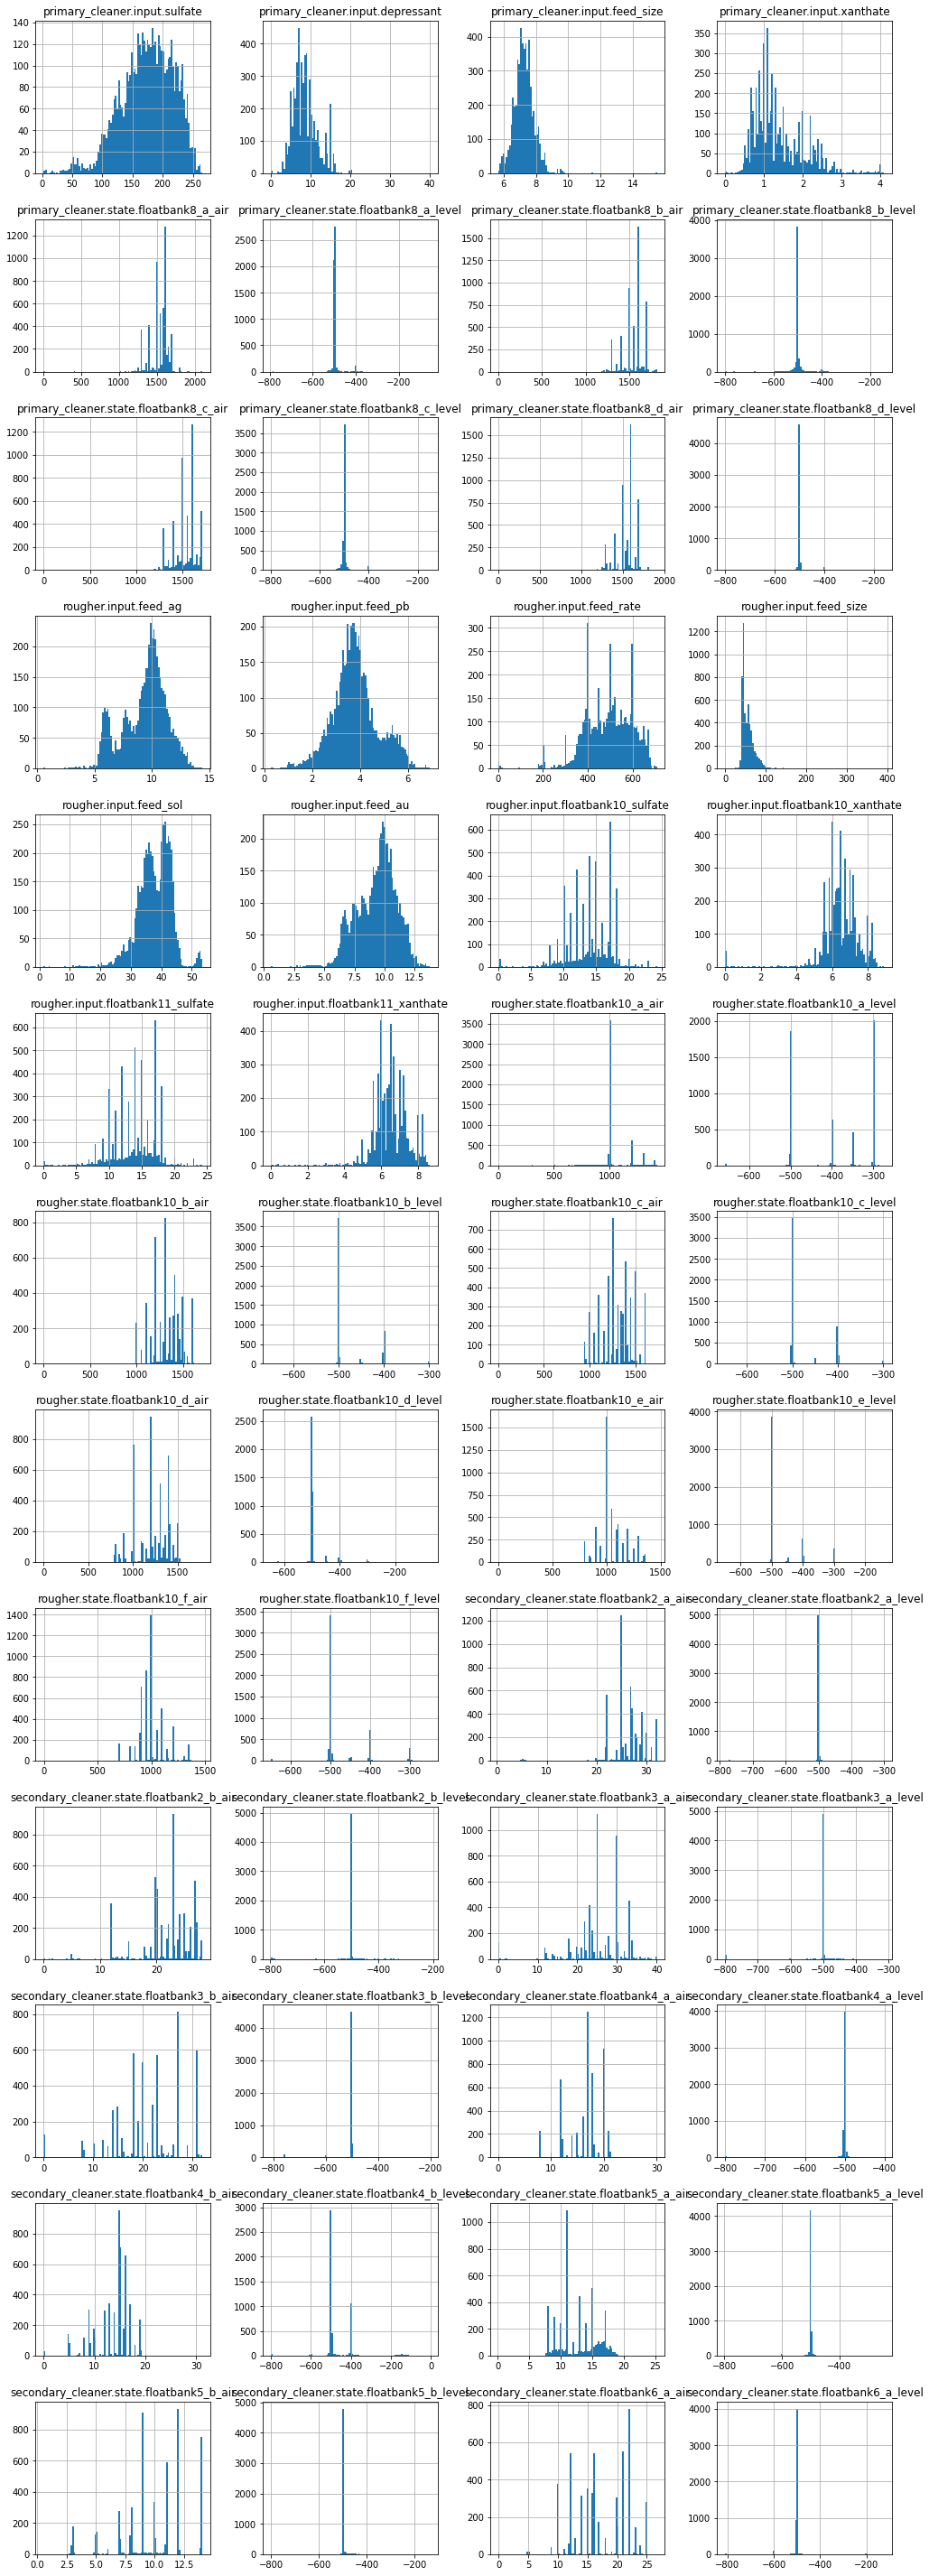

In [3]:
# загрузка и обзор данных в трех исходных файлах
data_full = zagr_obz('gold_recovery_full_new.csv')
data_train = zagr_obz('gold_recovery_train_new.csv')
data_test = zagr_obz('gold_recovery_test_new.csv')

Построим хитмэпы матриц корреляции для всех трех датасетов.

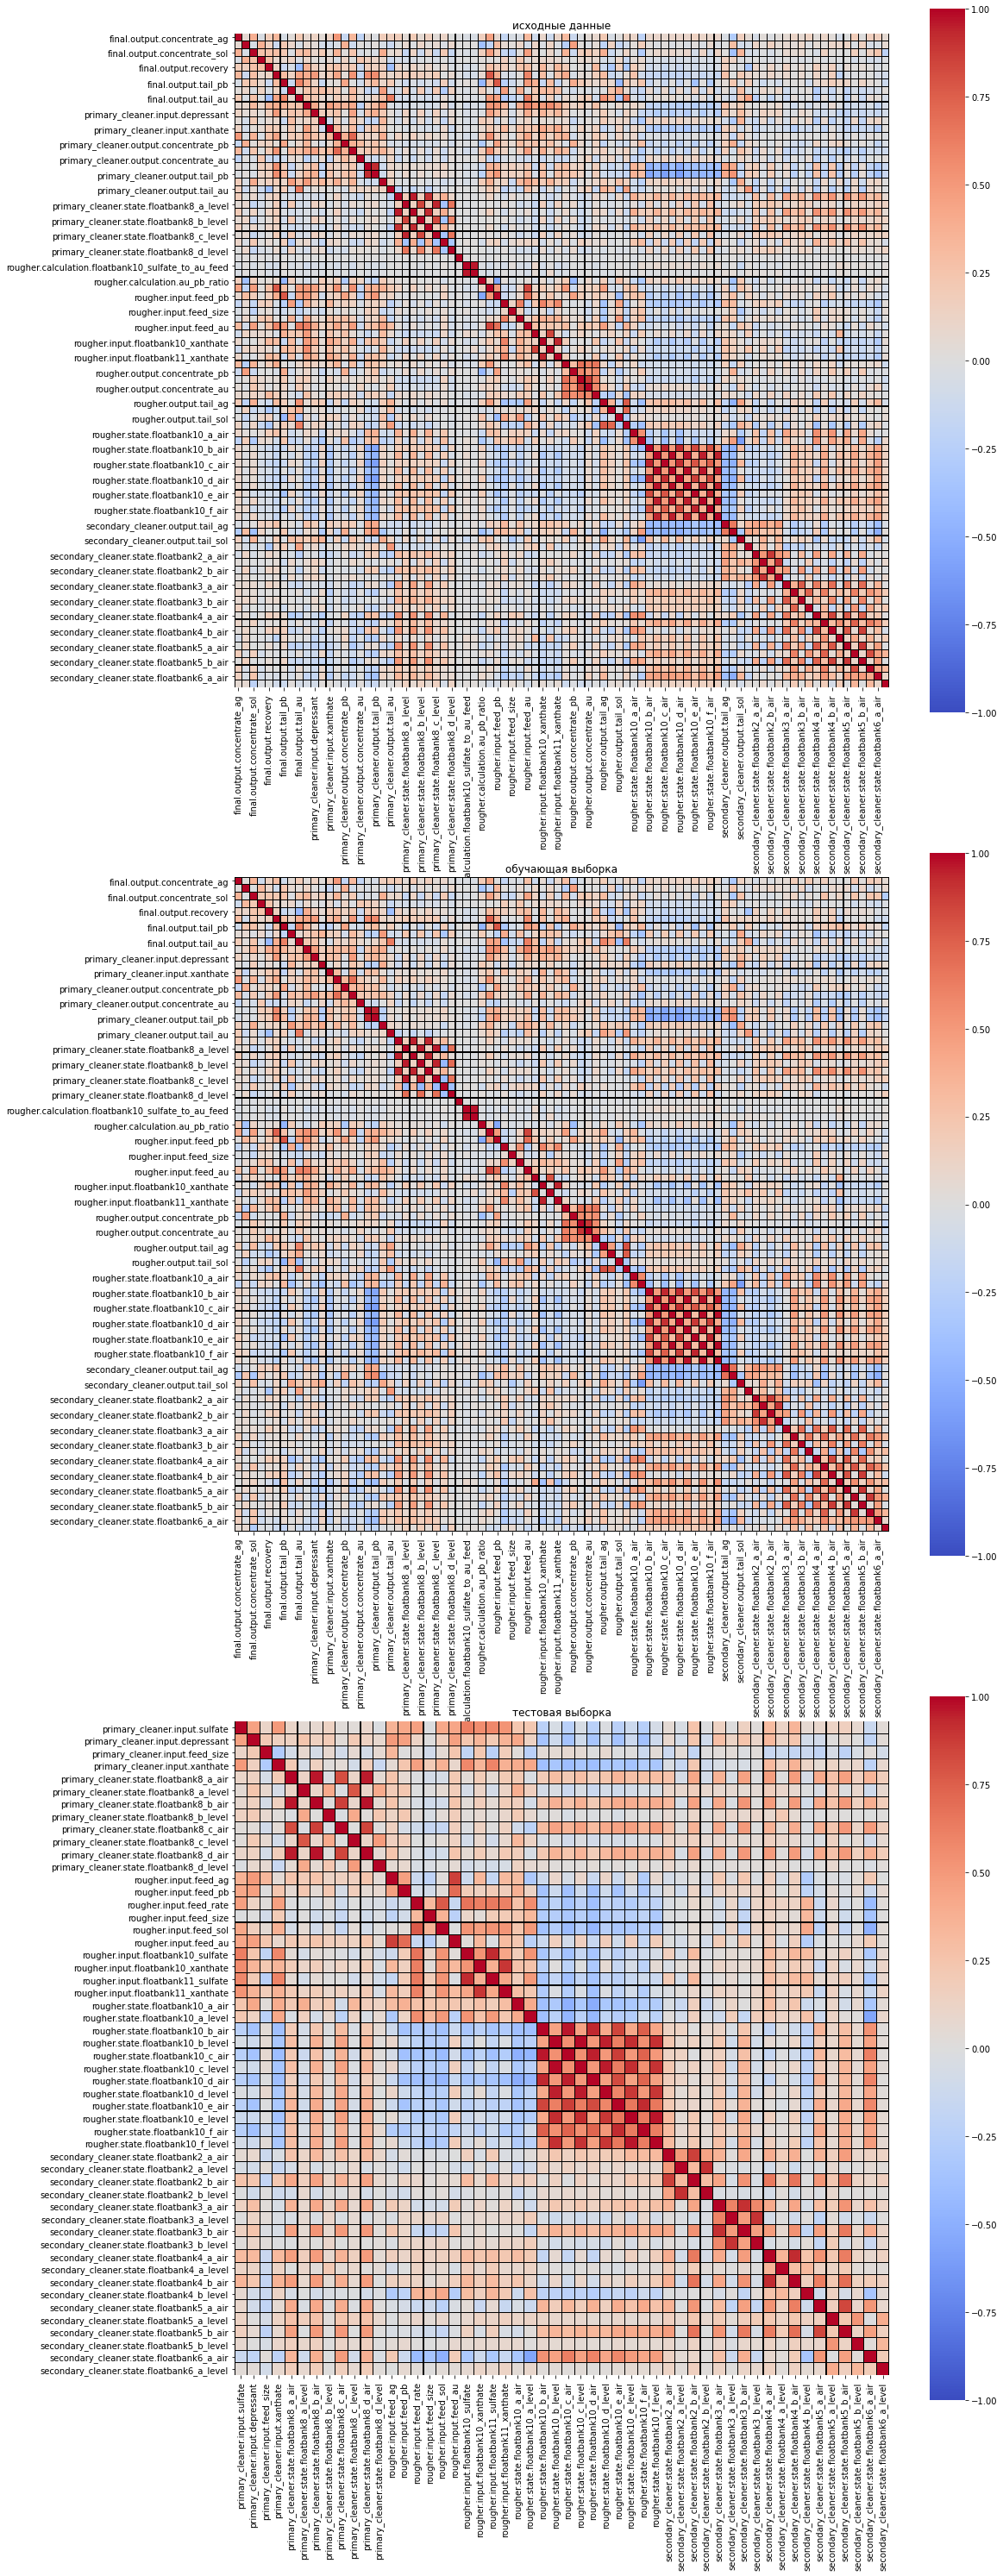

In [4]:
fig, axes = plt.subplots(3, 1, figsize=(17, 51))
sns.heatmap(data_full.corr(), vmin = -1, vmax = +1, cmap = 'coolwarm', square=True, linewidths=.1, linecolor='black', 
            ax=axes[0]).set(title='исходные данные')
sns.heatmap(data_train.corr(), vmin = -1, vmax = +1, cmap = 'coolwarm', square=True, linewidths=.1, linecolor='black', 
            ax=axes[1]).set(title='обучающая выборка')
sns.heatmap(data_test.corr(), vmin = -1, vmax = +1, cmap = 'coolwarm', square=True, linewidths=.1, linecolor='black', 
            ax=axes[2]).set(title='тестовая выборка')
plt.show()

Рассмотрев данные видим следующее:

- В исходных данных содержится 19,5 тыс. строк, что достаточно для проведения исследования.
- Дубликатов нет.
- Пропуски в данных есть, но процент пропусков низкий. Требуется отдельные мероприятия по удалению пропусков.
- Типы данных соответствуют содержанию. Дополнительно можно привести столбец `date` к формату дата-время.
- Параметры и целевые признаки в выборках являются количественными (числовыми). Графики распределения параметров построены.
- Корреляция между параметрами практически отсутствует. Единичные случаи сильной корреляции, судя по названию коррелирующих параметров, скорее всего, обусловлены особенностями технологического процесса.

### 1.2. <a id='toc1_2_'></a>[Проверка расчета эффективности обогащения](#toc0_)

Воспользуемся формулой расчета эффективности обогащения и проверим значения эффективности обогащения чернового концентрата, которые находятся в столбце `rougher.output.recovery` обучающей выборки.

MAE = 9.73512347450521e-15


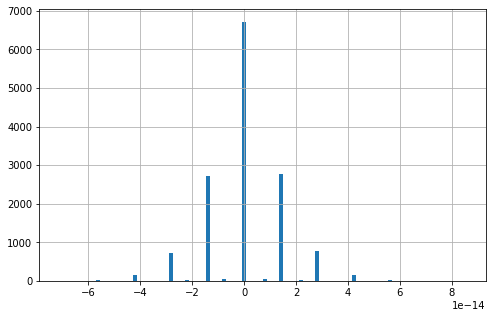

In [5]:
# сохраним значения для формулы эффективности
f = data_train['rougher.input.feed_au']
c = data_train['rougher.output.concentrate_au']
t = data_train['rougher.output.tail_au']
# в отдельный датафрейм запишем проверяемую эффективность
sverka = pd.DataFrame()
sverka['rougher.output.recovery'] = data_train['rougher.output.recovery']
# пересчитаем эффективность по формуле
sverka['rougher.output.recovery_raschet'] = ((c * (f - t)) / (f * (c - t))) * 100
# определим MAE
print('MAE =', mean_absolute_error(sverka['rougher.output.recovery'], sverka['rougher.output.recovery_raschet']))
# постороим гистограмму разницы
sverka['rougher.output.recovery_delta'] = sverka['rougher.output.recovery'] - sverka['rougher.output.recovery_raschet']
sverka['rougher.output.recovery_delta'].hist(bins=100, figsize=(8,5))
plt.show()

Аналогично проверим значения для эффективности обогащения финального концентрата `final.output.recovery`.

MAE = 8.538049763979541e-15


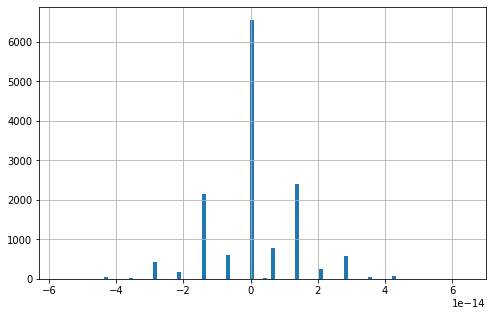

In [6]:
f1 = data_train['rougher.input.feed_au']
c1 = data_train['final.output.concentrate_au']
t1 = data_train['final.output.tail_au']
sverka['final.output.recovery'] = data_train['final.output.recovery']
sverka['final.output.recovery_raschet'] = ((c1 * (f1 - t1)) / (f1 * (c1 - t1))) * 100
print('MAE =', mean_absolute_error(sverka['final.output.recovery'], sverka['final.output.recovery_raschet']))
sverka['final.output.recovery_delta'] = sverka['final.output.recovery'] - sverka['final.output.recovery_raschet']
sverka['final.output.recovery_delta'].hist(bins=100, figsize=(8,5))
plt.show()

По результатам сравнения видим, что значения эффективности обогащения чернового и финального концентратов совпадают с расчетными значениями.

### 1.3. <a id='toc1_3_'></a>[Признаки, недоступные в тестовой выборке](#toc0_)


In [7]:
# выведем перечень признаков, отсутствующих в тестовой выборке
display(sorted(set(data_full.columns) - set(data_test.columns)))

['final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

В тестовой выборке отсутствуют следующие типы признаков:
1. Параметры продукта на разных стадиях обработки, имеющие в названии `output`. В том числе:
    - составляющие основного концентрата - смеси золотосодержащей руды (имеют в названии `concentrate`);
    - отвальные хвосты - остатки продукта с низкой концентрацией ценных металлов (имеют в названии `tail`);
    - два целевых признака:
        - эффективность обогащения чернового концентрата (`rougher.output.recovery`);
        - эффективность обогащения финального концентрата (`final.output.recovery`).
2. Расчётные характеристики (имеют в названии `calculation`).

Все признаки количественные (числовые), тип - с плавающей запятой.

### 1.4. <a id='toc1_4_'></a>[Предобработка данных](#toc0_)


В рамках предобработки данных установим для столбца `date` во всех трех датасетах тип дата-время.

In [8]:
data_full['date'] = data_full['date'].astype('datetime64[s]')
print(data_full.dtypes[0:1])
data_train['date'] = data_train['date'].astype('datetime64[s]')
print(data_train.dtypes[0:1])
data_test['date'] = data_test['date'].astype('datetime64[s]')
print(data_test.dtypes[0:1])

date    datetime64[ns]
dtype: object
date    datetime64[ns]
dtype: object
date    datetime64[ns]
dtype: object


Рассмотрим и обработаем пропуски.

In [9]:
# сброс ограничений на количество выводимых строк
pd.set_option('display.max_rows', None)
display(data_full.isna().agg('sum').sort_values(ascending=False).to_frame(name='пропущено').query('пропущено > 0')
        .join(round(data_full.isna().mean()*100, 1).sort_values(ascending=False).to_frame(name='пропущено, %')))
display(data_train.isna().agg('sum').sort_values(ascending=False).to_frame(name='пропущено').query('пропущено > 0')
        .join(round(data_train.isna().mean()*100, 1).sort_values(ascending=False).to_frame(name='пропущено, %')))
display(data_test.isna().agg('sum').sort_values(ascending=False).to_frame(name='пропущено').query('пропущено > 0')
        .join(round(data_test.isna().mean()*100, 1).sort_values(ascending=False).to_frame(name='пропущено, %')))
pd.set_option('display.max_rows', 10)

,пропущено,"пропущено, %"
secondary_cleaner.output.tail_sol,1748,9.0
rougher.input.floatbank11_xanthate,453,2.3
rougher.state.floatbank10_e_air,436,2.2
primary_cleaner.output.concentrate_sol,370,1.9
secondary_cleaner.state.floatbank2_a_air,220,1.1
final.output.concentrate_sol,211,1.1
rougher.input.feed_size,145,0.7
primary_cleaner.output.concentrate_pb,116,0.6
primary_cleaner.input.xanthate,104,0.5
final.output.tail_pb,101,0.5


,пропущено,"пропущено, %"
secondary_cleaner.output.tail_sol,1605,11.3
rougher.state.floatbank10_e_air,436,3.1
rougher.input.floatbank11_xanthate,428,3.0
primary_cleaner.output.concentrate_sol,286,2.0
secondary_cleaner.state.floatbank2_a_air,217,1.5
final.output.concentrate_sol,211,1.5
rougher.input.feed_size,144,1.0
primary_cleaner.input.xanthate,100,0.7
rougher.input.feed_pb,100,0.7
final.output.tail_pb,100,0.7


,пропущено,"пропущено, %"
rougher.input.floatbank11_xanthate,25,0.5
rougher.input.feed_sol,21,0.4
secondary_cleaner.state.floatbank3_a_air,9,0.2
rougher.input.floatbank11_sulfate,8,0.2
primary_cleaner.input.depressant,5,0.1
rougher.input.floatbank10_sulfate,5,0.1
primary_cleaner.input.xanthate,4,0.1
primary_cleaner.input.sulfate,4,0.1
rougher.input.feed_rate,3,0.1
secondary_cleaner.state.floatbank2_a_air,3,0.1


Данные описывают непрерывный во времени поток состояний процесса обработки на её этапах. При наличии пропусков в таких данных, с высокой вероятностью допустимо заполнить их предыдущими значениями из этого же потока данных.

In [10]:
# заполнение пропусков
data_full.fillna(method='ffill', inplace=True)
data_train.fillna(method='ffill', inplace=True)
data_test.fillna(method='ffill', inplace=True)
# проверка на наличие пропусков
display(data_full.isna().agg('sum').sort_values(ascending=False).to_frame(name='пропущено').query('пропущено > 0'))
display(data_train.isna().agg('sum').sort_values(ascending=False).to_frame(name='пропущено').query('пропущено > 0'))
display(data_test.isna().agg('sum').sort_values(ascending=False).to_frame(name='пропущено').query('пропущено > 0'))

,пропущено


,пропущено


,пропущено


### 1.5. <a id='toc1_5_'></a>[Вывод по результатам раздела 1](#toc0_)

Данные успешно загружены, в них содержится 19,5 тыс. строк, что достаточно для проведения исследования.

По результатам обследования и предобработки данных:
- дубликатов нет;
- пропуски заполнены;
- типы данных соответствуют содержанию;
- все признаки количественные (числовые), тип с плавающей запятой;
- корреляция между параметрами отсутствует, единичные случаи обусловлены особенностями технологического процесса;
- значения эффективности обогащения чернового и финального концентратов совпадают с расчетными значениями этих параметров;
- из тестовой выборки исключены параметры продукта на разных стадиях обработки (составляющие основного концентрата и отвальные хвосты), целевые признаки (эффективность обогащения чернового и финального концентратов) и расчётные характеристики.

## 2. <a id='toc2_'></a>[Анализ данных](#toc0_)

### 2.1. <a id='toc2_1_'></a>[Изменение концентрации металлов (Au, Ag, Pb) на различных этапах очистки](#toc0_)

Выведем названия столбцов, содержащие концентрации металлов, построим для них гистограммы и выведем медианные значения.

Названия столбцов с данными о концентрации металлов:


['rougher.input.feed_pb',
 'rougher.input.feed_au',
 'rougher.input.feed_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_au',
 'final.output.concentrate_ag']

Концентрация металлов (Pb, Au, Ag) на этапах технологического процесса:


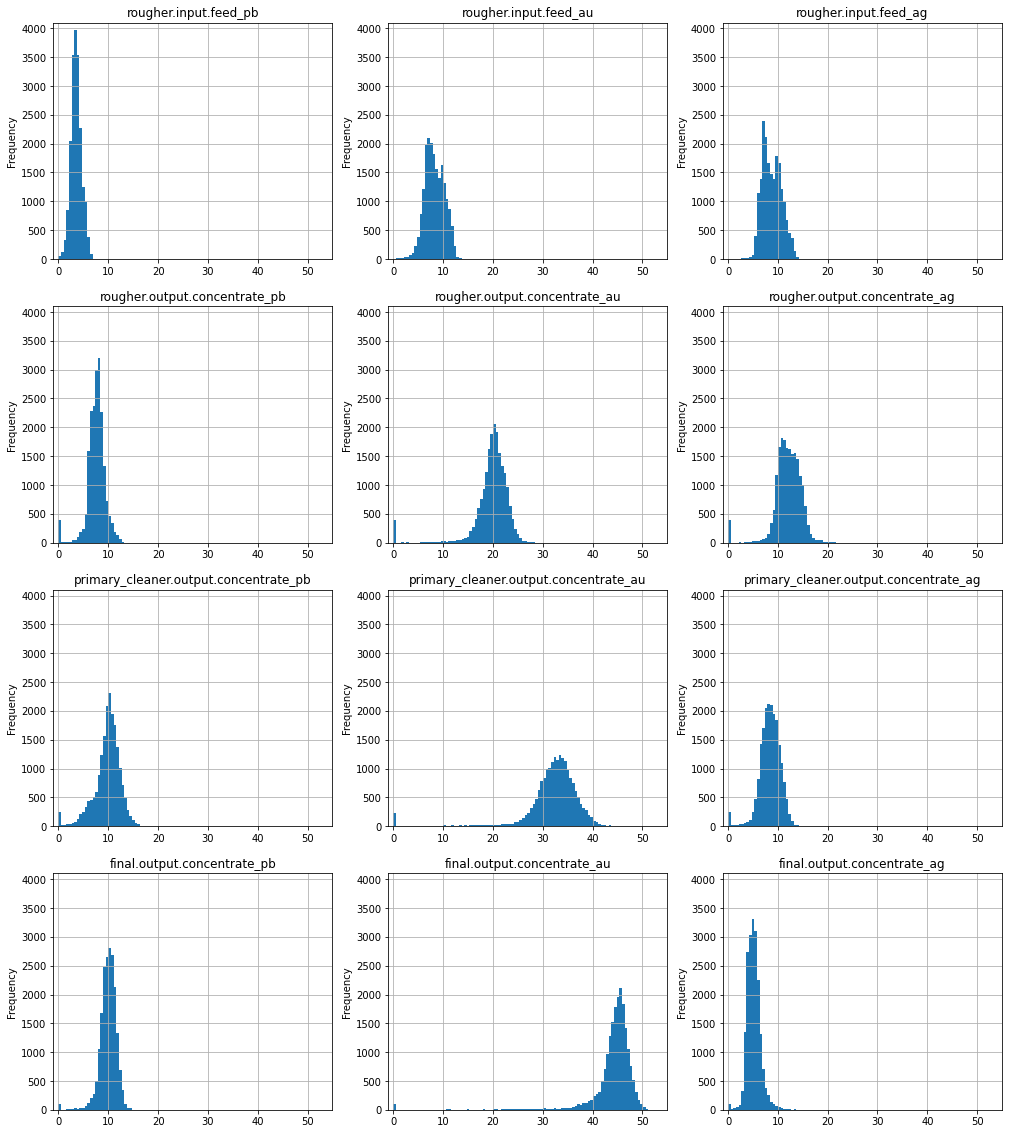


Медианные значения для концентраций Au (золота):
rougher.input.feed_au                     8.125839
rougher.output.concentrate_au            20.280214
primary_cleaner.output.concentrate_au    32.841295
final.output.concentrate_au              45.011244
dtype: float64

Медианные значения для концентраций Ag (серебра):
rougher.input.feed_ag                     8.593574
rougher.output.concentrate_ag            12.098115
primary_cleaner.output.concentrate_ag     8.507298
final.output.concentrate_ag               5.066039
dtype: float64

Медианные значения для концентраций Pb (свинца):
rougher.input.feed_pb                     3.528235
rougher.output.concentrate_pb             7.742580
primary_cleaner.output.concentrate_pb    10.142270
final.output.concentrate_pb              10.102264
dtype: float64


In [11]:
# выделение столбцов с данными
metal = sorted(list(data_full.columns[data_full.columns.str.contains('au|ag|pb') & 
                                  data_full.columns.str.contains('output.concentrate|input')]), reverse=True)
metal[0:3],metal[3:7] = metal[3:7],metal[0:3]
print('Названия столбцов с данными о концентрации металлов:')
display(metal)

# построение графиков
print('Концентрация металлов (Pb, Au, Ag) на этапах технологического процесса:')
data_full[metal].plot(kind='hist', bins=100, figsize=(17,20), layout=(4,3), subplots=True, color='#1f77b4', grid=True, 
                      xlim=(-1, 55), ylim=(0, 4100), sharex=False, title=metal, legend=False)
plt.show()

# вычисление медиан
print(f'''
Медианные значения для концентраций Au (золота):
{data_full[metal[1:12:3]].median()}

Медианные значения для концентраций Ag (серебра):
{data_full[metal[2:12:3]].median()}

Медианные значения для концентраций Pb (свинца):
{data_full[metal[0:12:3]].median()}''')

Рассмотрев медианные значения и графики концентраций металлов на этапах технологического процесса, можем сделать следующие выводы:
1. Au, золото (средняя вертикаль графиков).  
Концентрация основного инградиента увеличивается с 8% на входе до 45% на выходе, что и является основной задачей технологического процесса восстановления золота из золотосодержащей руды.
2. Ag, серебро (правая вертикаль графиков и Pb, свинец (левая вертикаль графиков).  
Концентрация неосновных инградиентов на этапах процесса практически не изменяется.

Аналогично рассмотрим концентрации "отвальных хвостов".

Названия столбцов с данными об отвальных хвостах:


['rougher.output.tail_sol',
 'rougher.output.tail_pb',
 'rougher.output.tail_au',
 'rougher.output.tail_ag',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_ag',
 'secondary_cleaner.output.tail_sol',
 'secondary_cleaner.output.tail_pb',
 'secondary_cleaner.output.tail_au',
 'secondary_cleaner.output.tail_ag',
 'final.output.tail_sol',
 'final.output.tail_pb',
 'final.output.tail_au',
 'final.output.tail_ag']

Графики концентраций Sol, Pb, Au и Ag в "отвальных хвостах" на этапах процесса:


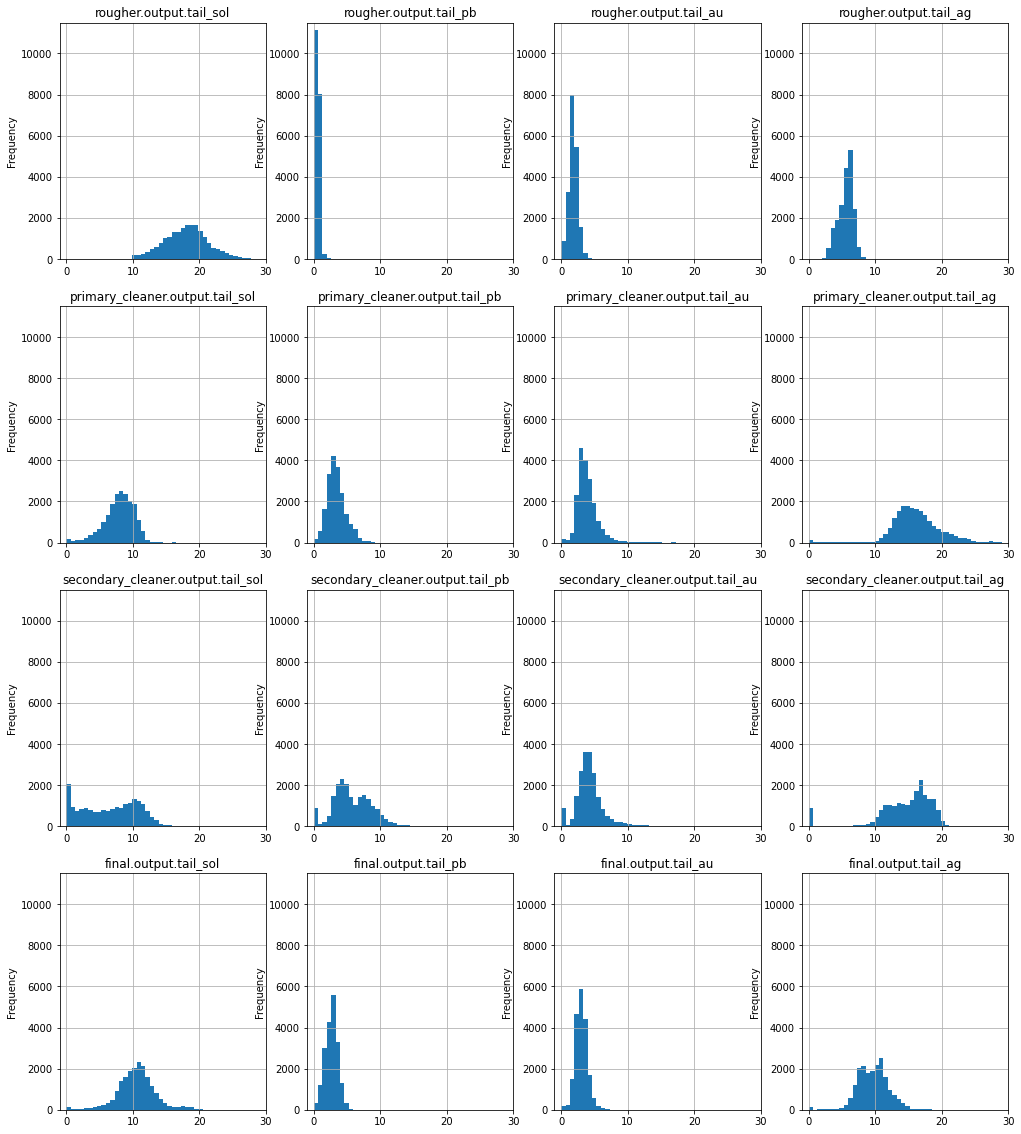


Медианные значения для концентраций Sol (соли):
rougher.output.tail_sol              18.106867
primary_cleaner.output.tail_sol       8.179794
secondary_cleaner.output.tail_sol     7.086606
final.output.tail_sol                10.622340
dtype: float64

Медианные значения для концентраций Pb (свинца):
rougher.output.tail_pb              0.617465
primary_cleaner.output.tail_pb      3.269958
secondary_cleaner.output.tail_pb    5.343407
final.output.tail_pb                2.743965
dtype: float64

Медианные значения для концентраций Au (золота):
rougher.output.tail_au              1.808170
primary_cleaner.output.tail_au      3.623234
secondary_cleaner.output.tail_au    4.072412
final.output.tail_au                2.984909
dtype: float64

Медианные значения для концентраций Ag (серебра):
rougher.output.tail_ag               5.765829
primary_cleaner.output.tail_ag      15.842836
secondary_cleaner.output.tail_ag    15.640668
final.output.tail_ag                 9.743106
dtype: float64


In [12]:
# выделение столбцов с данными
hvost = sorted(list(data_full.columns[data_full.columns.str.contains('tail')]), reverse=True)
hvost[0:8],hvost[8:12] = hvost[4:12],hvost[0:4]
print('Названия столбцов с данными об отвальных хвостах:')
display(hvost)

# построение графиков
print('Графики концентраций Sol, Pb, Au и Ag в "отвальных хвостах" на этапах процесса:')
data_full[hvost].plot(kind='hist', bins=100, figsize=(17,20), layout=(4,4), subplots=True, color='#1f77b4', grid=True, 
                      xlim=(-1, 30), ylim=(0, 11500), sharex=False, title=hvost, legend=False)
plt.show()

# вычисление медиан
print(f'''
Медианные значения для концентраций Sol (соли):
{data_full[hvost[0:16:4]].median()}

Медианные значения для концентраций Pb (свинца):
{data_full[hvost[1:16:4]].median()}

Медианные значения для концентраций Au (золота):
{data_full[hvost[2:16:4]].median()}

Медианные значения для концентраций Ag (серебра):
{data_full[hvost[3:16:4]].median()}''')

Особых закономерностей в распределениях нет.  
Видим, что в "отвальных хвостах" большая концентрация Sol (солей) и незначительная концентрация металлов.

Исключение составляет Ag (серебро), имеющее высокую концентрацию в составе "отвальных хвостов" на выходе первого и второго этапов очистки. Скорее всего, это связано с особенностями технологического процесса и "отвальные хвосты" после первого и второго этапов очистки далее проходят дополнительную обработку по извлечению Ag (серебра).

### 2.2. <a id='toc2_2_'></a>[Сравнение распределения размеров гранул сырья на обучающей и тестовой выборках](#toc0_)


In [13]:
razmer = sorted(list(data_full.columns[data_full.columns.str.contains('size')]), reverse=True)
print('Столбцы с данными о размерах гранул:')
display(razmer)

Столбцы с данными о размерах гранул:


['rougher.input.feed_size', 'primary_cleaner.input.feed_size']

Графики распределения размеров гранул:


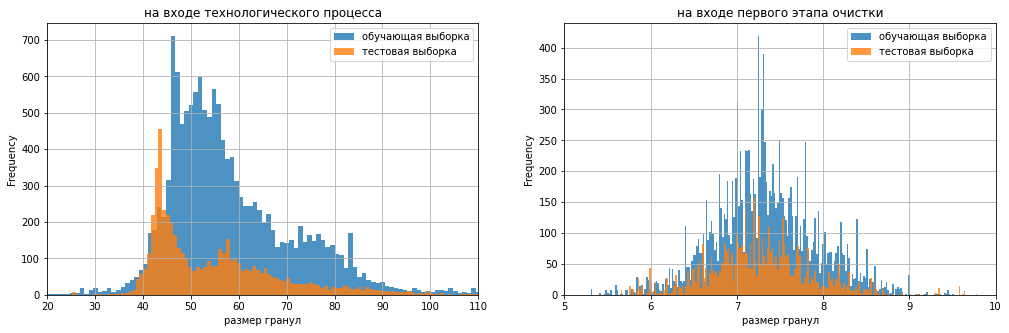

In [14]:
# построение графиков
print('Графики распределения размеров гранул:')
data_train['rougher.input.feed_size'].plot(kind='hist', bins=500, figsize=(17,5), ax=plt.subplot(1, 2, 1), 
                                           xlim=(20, 110), alpha=.8)
data_test['rougher.input.feed_size'].plot(kind='hist', bins=500, grid=True, title='на входе технологического процесса',
                                         alpha=.8)
plt.xlabel('размер гранул')
plt.legend(['обучающая выборка', 'тестовая выборка'])
data_train['primary_cleaner.input.feed_size'].plot(kind='hist', bins=500, figsize=(17,5), ax=plt.subplot(1, 2, 2), 
                                                   xlim=(5, 10), alpha=.8)
data_test['primary_cleaner.input.feed_size'].plot(kind='hist', bins=500, grid=True, title='на входе первого этапа очистки',
                                                 alpha=.8)
plt.xlabel('размер гранул')
plt.legend(['обучающая выборка', 'тестовая выборка'])
plt.show()

В качестве альтернативы гистограммам построим графики плотности kde (по оси y откладывается доля относительно датасета вместо абсолютного количества), которые позволяют более качественно сравнить выборки разного размера.

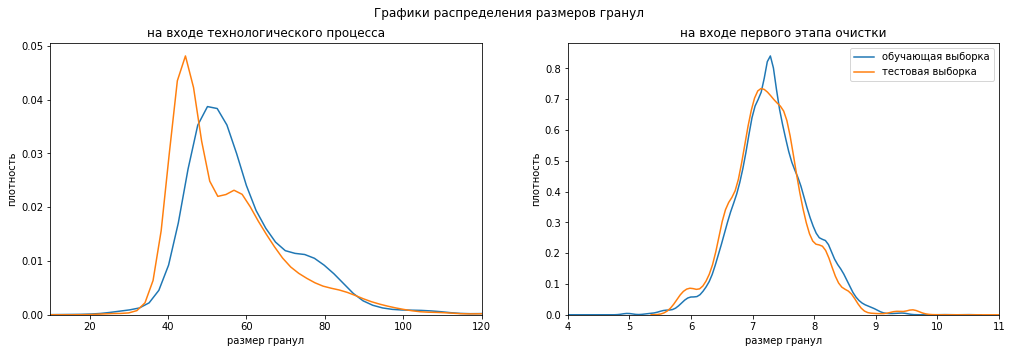

In [15]:
# построение графиков плотности (kde)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(17, 5))
fig.suptitle('Графики распределения размеров гранул')
sns.kdeplot(x='rougher.input.feed_size', data=data_train, ax=ax[0], bw_adjust=.9)
sns.kdeplot(x='rougher.input.feed_size', data=data_test, ax=ax[0], bw_adjust=.9)
ax[0].set_title('на входе технологического процесса')
ax[0].set_xlabel('размер гранул')
ax[0].set_ylabel('плотность')
ax[0].set_xlim(10, 120)
sns.kdeplot(x='primary_cleaner.input.feed_size', data=data_train, ax=ax[1], bw_adjust=.9)
sns.kdeplot(x='primary_cleaner.input.feed_size', data=data_test, ax=ax[1], bw_adjust=.9)
ax[1].set_title('на входе первого этапа очистки')
ax[1].set_xlabel('размер гранул')
ax[1].set_ylabel('плотность')
ax[1].set_xlim(4, 11) 
plt.legend(['обучающая выборка', 'тестовая выборка'])
plt.show()

Видим, что графики размеров гранул на входе технологического процесса и на входе первого этапа очистки в обучающей и тестовой выборках имеют сходную форму и диапазон распределения.  
На входе первого этапа очистки сходство очень велико.  
На входе технологического процесса есть некоторые отличия и небольшое смещение в форме графиков. Это не должно сильно повлиять на результаты. Кроме того, данные, которые должны попадать в тестовую выборку, определил Заказчик, и на текущий момент изменение состава тестовой выборки не предполагается.

### 2.3. <a id='toc2_3_'></a>[Исследование суммарной концентрации веществ на стадиях технологического процесса](#toc0_)

В пункте 2.1 мы определили названия столбцов, содержащих концентрацию металлов на входе и этапах технологического процесса.

In [16]:
print('Названия столбцов с данными о концентрации веществ на входе и стадиях технологического процесса:')
display(metal)

Названия столбцов с данными о концентрации веществ на входе и стадиях технологического процесса:


['rougher.input.feed_pb',
 'rougher.input.feed_au',
 'rougher.input.feed_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_au',
 'final.output.concentrate_ag']

Построим гистограммы суммарной концентрации веществ на этапах технологического процесса и сравним.

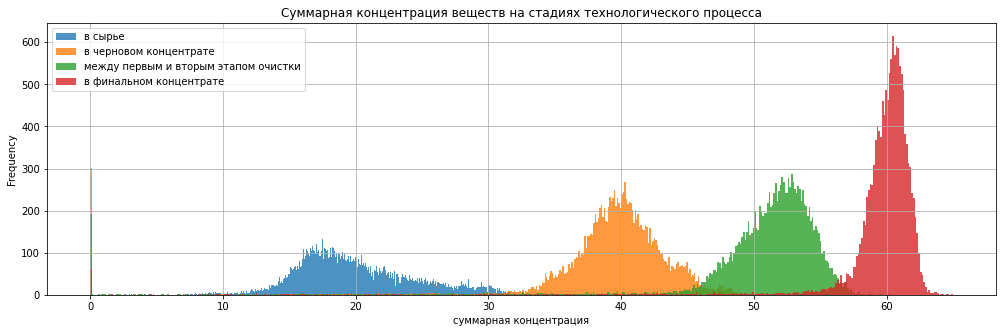

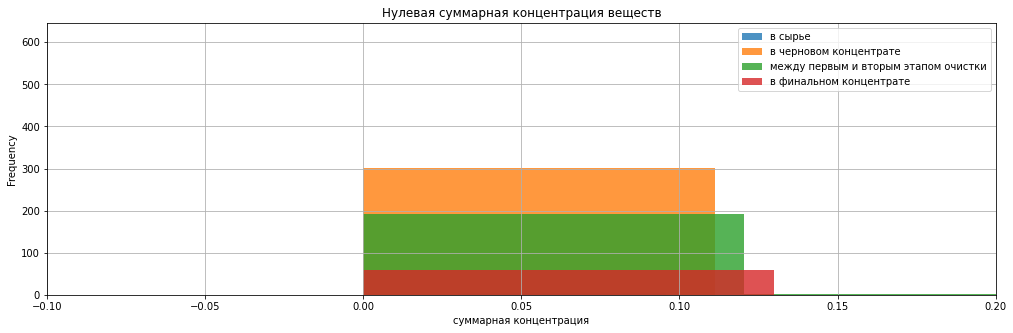

In [18]:
data_train[metal[0:3]].sum(axis=1).plot(kind='hist', bins=500, figsize=(17,5), alpha=.8,
                                       title='Суммарная концентрация веществ на стадиях технологического процесса')
data_train[metal[3:6]].sum(axis=1).plot(kind='hist', bins=500, alpha=.8)
data_train[metal[6:9]].sum(axis=1).plot(kind='hist', bins=500, alpha=.8)
data_train[metal[9:12]].sum(axis=1).plot(kind='hist', bins=500, alpha=.8, grid=True)
plt.xlabel('суммарная концентрация')
plt.legend(['в сырье', 'в черновом концентрате', 'между первым и вторым этапом очистки', 'в финальном концентрате'])
plt.show()

data_train[metal[0:3]].sum(axis=1).plot(kind='hist', bins=500, figsize=(17,5), alpha=.8, xlim=(-.1,.2),
                                       title='Нулевая суммарная концентрация веществ')
data_train[metal[3:6]].sum(axis=1).plot(kind='hist', bins=500, alpha=.8)
data_train[metal[6:9]].sum(axis=1).plot(kind='hist', bins=500, alpha=.8)
data_train[metal[9:12]].sum(axis=1).plot(kind='hist', bins=500, alpha=.8, grid=True)
plt.xlabel('суммарная концентрация')
plt.legend(['в сырье', 'в черновом концентрате', 'между первым и вторым этапом очистки', 'в финальном концентрате'])
plt.show()

На графиках просматриваются две основные закономерности:
1. Концентрация веществ (металлов) по мере прохождения по стадиям технологического процесса растет и достигает максимума на выходе. В первую очередь, как мы видели в пункте 2.1, это относится к золоту. 
2. Разброс концентрации по мере прохождения по стадиям технологического процесса уменьшается и достигает минимума на выходе.

Выбросы в районе нулевых концентраций - это аномальные значения, скорее всего, связанные с неточностью в измерениях.
   
Удалим аномальные значения и построим итоговый график концентрации веществ на этапах технологического процесса.

In [19]:
# количество строк с нулевой (меньше 0,15) концентрацией веществ
print(sum(data_train[metal[0:3]].sum(axis=1) < .15))
print(sum(data_train[metal[3:6]].sum(axis=1) < .15))
print(sum(data_train[metal[6:9]].sum(axis=1) < .15))
print(sum(data_train[metal[9:12]].sum(axis=1) < .15))

5
302
192
59


In [20]:
# удаление строк с нулевой (меньше 0,15) концентрацией веществ
data_train = data_train[data_train[metal[0:3]].sum(axis=1) > .15]
data_train = data_train[data_train[metal[3:6]].sum(axis=1) > .15]
data_train = data_train[data_train[metal[6:9]].sum(axis=1) > .15]
data_train = data_train[data_train[metal[9:12]].sum(axis=1) > .15]

0
0
0
0


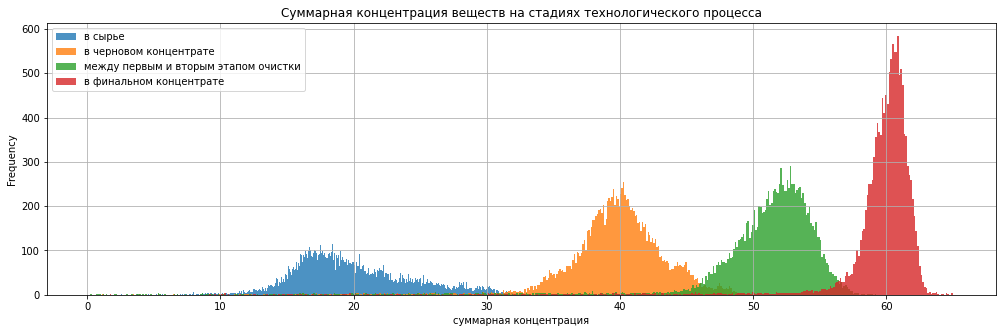

In [21]:
# проверка
print(sum(data_train[metal[0:3]].sum(axis=1) < .15))
print(sum(data_train[metal[3:6]].sum(axis=1) < .15))
print(sum(data_train[metal[6:9]].sum(axis=1) < .15))
print(sum(data_train[metal[9:12]].sum(axis=1) < .15))

data_train[metal[0:3]].sum(axis=1).plot(kind='hist', bins=500, figsize=(17,5), alpha=.8,
                                       title='Суммарная концентрация веществ на стадиях технологического процесса')
data_train[metal[3:6]].sum(axis=1).plot(kind='hist', bins=500, alpha=.8)
data_train[metal[6:9]].sum(axis=1).plot(kind='hist', bins=500, alpha=.8)
data_train[metal[9:12]].sum(axis=1).plot(kind='hist', bins=500, alpha=.8, grid=True)
plt.xlabel('суммарная концентрация')
plt.legend(['в сырье', 'в черновом концентрате', 'между первым и вторым этапом очистки', 'в финальном концентрате'])
plt.show()

### 2.4. <a id='toc2_4_'></a>[Вывод по результатам раздела 2](#toc0_)

Анализ данных о составе, концентрации и размере гранул веществ на этапах технологического процесса позволяет сделать следующие выводы:
- В рамках технологического процесса восстановления золота из золотосодержащей руды концентрация основного инградиента (Au, золото) увеличивается с 8% до 45%.
- Концентрация неосновных инградиентов на этапах процесса практически не изменяется.
- Особых закономерностей в распределениях "отвальных хвостов" нет. В их составе большая концентрация Sol (солей) и незначительная концентрация металлов, за исключеним Ag (серебра), имеющего высокую концентрацию в составе "отвальных хвостов" на выходе первого и второго этапов очистки, что, предположительно, связано с особенностями технологического процесса.
- Форма графиков и диапазон распределения размеров гранул на входе технологического процесса и на входе первого этапа очистки в обучающей и тестовой выборках большей частью совпадают. Небольшие отличия в форме графиков на входе технологического процесса не должно сильно повлиять на результат. Также необходимо учитывать, что данные для тестовой выборки четко определены Заказчиком и в данный момент не подлежат изменению.
- Концентрация веществ (в первую очередь, золота) по мере прохождения по стадиям технологического процесса растет и на выходе достигает своего максимума. При этом разброс концентрации уменьшается и на выходе достигает своего минимума.

## 3. <a id='toc3_'></a>[Построение, обучение и оценка моделей](#toc0_)

### 3.1. <a id='toc3_1_'></a>[Функция для вычисления итоговой sMAPE.](#toc0_)

Сначала напишем функцию для расчета sMAPE, которую будем применять при вычислении итогового sMAPE.

In [22]:
# функция расчета метрики sMAPE
# на входе целевые значения и предсказания, на выходе значение sMAPE
def smape_rasch(targ, predict):
    res = ((np.abs(targ - predict) / ((np.abs(targ) + np.abs(predict)) / 2)) *100).mean()
    return res

Напишем функцию расчета итогового sMAPE.

In [23]:
# функция расчета итогового sMAPE
# на входе целевые значения и предсказания на этапе чернового концентрата (rougher) и на финального концентрата (final)
# на выходе значение итогового sMAPE
def smape_total(target_rougher, predict_rougher, target_final, predict_final):
    smape_tot = .25 * smape_rasch(target_rougher, predict_rougher) + .75 * smape_rasch(target_final, predict_final)
    return smape_tot

### 3.2. <a id='toc3_2_'></a>[Подготовка обучающей и тестовой выборок](#toc0_)

Исходные данные изначально разделены Заказчиком на обучающую и тестовую выборки (`data_train` и `data_test` соответственно).

Другая особенность связана с тем, что нам необходимо предсказать целевой параметр (эффективность обогащения) в двух точках технологического процесса - на этапах чернового и финального концентратов. Поэтому параметры, возникающие после этапа чернового концентрата, необходимо убрать из обучающей выборки для предсказания эффективность обогащения на этапе чернового концентрата.

Таким образом, для подготовки выборок необходимо выполнить следующие действия:
- удалить из предоставленной обучающей выборки столбцы с данными, не являющиеся признаками (по аналогии с составом данных в тестовой выборке);
- удалить столбец `date`, не являющийся признаком;
- сформировать отдельную обучающую и тестовую выборки для этапа чернового концентрата, не содержащую параметры, которые появляются на более поздних этапах технологического процесса;
- разделить на отдельные датасеты признаки и целевой признак.

In [24]:
# создадим выборки с признаками для этапа финального концентрата
features_train_final = data_train.drop(columns=(set(data_full.columns) - set(data_test.columns))).drop(columns='date')
features_test_final = data_test.drop(columns='date')
# создадим выборки с признаками для этапа чернового концентрата
features_train_rougher = features_train_final.drop(
    columns=list(features_train_final.columns[features_train_final.columns.str.contains('primary|secondary')]))
features_test_rougher = features_test_final.drop(
    columns=list(features_train_final.columns[features_train_final.columns.str.contains('primary|secondary')]))
# создадим выборки с целевыми признаками
target_train_rougher = data_train['rougher.output.recovery']
target_train_final = data_train['final.output.recovery']
target_test_rougher = pd.merge(data_test[['date']], data_full[['date', 'rougher.output.recovery']], 
                       how='left', on=['date']).drop(columns='date').squeeze()
target_test_final = pd.merge(data_test[['date']], data_full[['date', 'final.output.recovery']], 
                       how='left', on=['date']).drop(columns='date').squeeze()
print(f'''
Для этапа чернового концентрата.
    Обучающая выборка (features_train_rougher, target_train_rougher):
        - признаки {features_train_rougher.shape};
        - целевые признаки {target_train_rougher.shape[0]}.
    Тестовая выборка (features_test_rougher, target_test_rougher):
        - признаки {features_test_rougher.shape};
        - целевые признаки {target_test_rougher.shape[0]}.
        
Для этапа финального концентрата.
    Обучающая выборка (features_train_final, target_train_final):
        - признаки {features_train_final.shape};
        - целевые признаки {target_train_final.shape[0]}.
    Тестовая выборка (features_test_final, target_test_final):
        - признаки {features_test_final.shape};
        - целевые признаки {target_test_final.shape[0]}.
''')


Для этапа чернового концентрата.
    Обучающая выборка (features_train_rougher, target_train_rougher):
        - признаки (13601, 22);
        - целевые признаки 13601.
    Тестовая выборка (features_test_rougher, target_test_rougher):
        - признаки (5290, 22);
        - целевые признаки 5290.
        
Для этапа финального концентрата.
    Обучающая выборка (features_train_final, target_train_final):
        - признаки (13601, 52);
        - целевые признаки 13601.
    Тестовая выборка (features_test_final, target_test_final):
        - признаки (5290, 52);
        - целевые признаки 5290.



### 3.3. <a id='toc3_3_'></a>[Обучение моделей и оценка их качества](#toc0_)

Для прогнозирования целевых параметров будем использовать четыре модели двух разных классов:
- класс "регрессии":
    - обычная линейная регрессия (`LinearRegression`);
    - линейная регрессия с L2 регуляризацией (`Ridge`);
- класс "деревья":
    - дерево решений (`DecisionTreeRegressor`);
    - случайный лес (`RandomForestRegressor`).
    
Для всех моделей в качестве предобработки применим масштабирование параметров (`StandardScaler`). Подбор гиперпараметров осуществим с помощью `GridSearchCV` и кросс-валидации с параметром `cv=5` на обучающей выборке. Для создания сквозного процесса используем пайплайн (`Pipeline`).

Для оценки результата создадим пользовательскую метрику на базе функции расчета симметричного среднего абсолютного процентного отклонения `sMAPE`, которую мы написали в пункте 3.1. Чем меньше `sMAPE`, тем лучше модель.

Для удобства многократного использования оформим подбор гиперпараметров каждой из моделей в виде отдельных функций.

Подбирать гиперпараметры и находить лучшие модели будем для двух этапов: чернового концентрата и финального концентрата.

#### 3.3.1. <a id='toc3_3_1_'></a>[Модель линейная регрессия (LinearRegression)](#toc0_)

Для модели линейной регрессии не требуется подбор гиперпараметров, поэтому будем просто обучать модель с применением кросс-валидации.

In [25]:
# функция обучения модели 'LinearRegression' с применением кросс-валидации
# на входе выборки с параметрами и целевым параметром
# на выходе модель и лучшее sMAPE
def lg_cv(features, target):
    # создание пайплайн
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', LinearRegression())
        ])
    # определение пользовательской метрики sMAPE на базе функции 'smape_rasch'
    custom_scorer = make_scorer(smape_rasch, greater_is_better=False)
    # применение кросс-валидации
    lg = cross_val_score(pipe, features, target, scoring=custom_scorer, cv=5, n_jobs=-1)
    smape_best = -sum(lg) / len(lg)
    # вывод результатов
    print(f'''
Модель "линейная регрессия"
Лучшее sMAPE: {smape_best}
    ''')
    return lg, smape_best

In [26]:
print('Этап чернового концентрата:')
mod_lg_cv_r, smape_lg_cv_r = lg_cv(features_train_rougher, target_train_rougher)

print('Этап финального концентрата:')
mod_lg_cv_f, smape_lg_cv_f = lg_cv(features_train_final, target_train_final)

Этап чернового концентрата:

Модель "линейная регрессия"
Лучшее sMAPE: 6.673975816238817
    
Этап финального концентрата:

Модель "линейная регрессия"
Лучшее sMAPE: 11.019679533267114
    


#### 3.3.2. <a id='toc3_3_2_'></a>[Модель линейная регрессия с L2 регуляризацией (Ridge)](#toc0_)

Данная модель имеет улучшения по сравнению с простой линейной регрессией, позволяет уменьшить вероятность переобучения и более устойчива к мультиколлинеарности. Минимальный подбор гиперпараметров присутствует.

In [27]:
# функция подбора гиперпараметров для 'Ridge' с помощью 'GridSearchCV'
# на входе выборки с параметрами и целевым параметром
# на выходе модель, лучшее sMAPE и набор лучших гиперпараметров в виде Series
def rid_gscv(features, target):
    # создание пайплайн
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', Ridge(random_state=RST))
        ])
    # определение параметров и их диапазона для подбора
    param_grid = [{
        'regressor__alpha': range(1, 101, 10),
        'regressor__solver': ['svd', 'cholesky', 'lsqr']
        }]
    # определение пользовательской метрики sMAPE на базе функции 'smape_rasch'
    custom_scorer = make_scorer(smape_rasch, greater_is_better=False)
    # подбор гиперпараметров с использованием кросс-валидации
    rid_gs = GridSearchCV(pipe, param_grid=param_grid, scoring=custom_scorer, cv=5, n_jobs=-1, verbose=1)
    rid_gs.fit(features, target)
    smape_best = -rid_gs.best_score_
    param_best = pd.Series(rid_gs.best_params_)    
    # вывод результатов
    print(f'''
Модель "линейная регрессия с L2 регуляризацией"
Лучшее sMAPE: {smape_best}
Лучшие гиперпараметры:
{param_best}
    ''')
    return rid_gs, smape_best, param_best

In [28]:
print('Этап чернового концентрата:')
mod_rid_gs_r, smape_rid_gs_r, param_rid_gs_r = rid_gscv(features_train_rougher, target_train_rougher)

print('Этап финального концентрата:')
mod_rid_gs_f, smape_rid_gs_f, param_rid_gs_f = rid_gscv(features_train_final, target_train_final)

Этап чернового концентрата:
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Модель "линейная регрессия с L2 регуляризацией"
Лучшее sMAPE: 6.532723292402251
Лучшие гиперпараметры:
regressor__alpha       91
regressor__solver    lsqr
dtype: object
    
Этап финального концентрата:
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Модель "линейная регрессия с L2 регуляризацией"
Лучшее sMAPE: 10.63846327776481
Лучшие гиперпараметры:
regressor__alpha       91
regressor__solver    lsqr
dtype: object
    


#### 3.3.3. <a id='toc3_3_3_'></a>[Модель дерево решений (DecisionTreeRegressor)](#toc0_)

В отличии от регрессий, модель другого класса. Для более качественной работы модели необходим подбор гиперпараметров.

In [29]:
# функция подбора гиперпараметров для 'DecisionTreeRegressor' с помощью 'GridSearchCV'
# на входе выборки с параметрами и целевым параметром
# на выходе модель, лучшее sMAPE и набор лучших гиперпараметров в виде Series
def dtr_gscv(features, target):
    # создание пайплайн
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', DecisionTreeRegressor(random_state=RST))
        ])
    # определение параметров и их диапазона для подбора
    param_grid = [{
        'regressor__max_depth': range(2, 8, 2),
        'regressor__min_samples_leaf': range(1, 16, 5),
        'regressor__min_samples_split': range(2, 8, 2)
        }]
    # определение пользовательской метрики sMAPE на базе функции 'smape_rasch'
    custom_scorer = make_scorer(smape_rasch, greater_is_better=False)
    # подбор гиперпараметров с использованием кросс-валидации
    dtr_gs = GridSearchCV(pipe, param_grid=param_grid, scoring=custom_scorer, cv=5, n_jobs=-1, verbose=1)
    dtr_gs.fit(features, target)
    smape_best = -dtr_gs.best_score_
    param_best = pd.Series(dtr_gs.best_params_)    
    # вывод результатов
    print(f'''
Модель "дерево решений"
Лучшее sMAPE: {smape_best}
Лучшие гиперпараметры:
{param_best}
    ''')
    return dtr_gs, smape_best, param_best

Этап чернового концентрата:
Fitting 5 folds for each of 27 candidates, totalling 135 fits

Модель "дерево решений"
Лучшее sMAPE: 7.090231247922591
Лучшие гиперпараметры:
regressor__max_depth            6
regressor__min_samples_leaf     1
regressor__min_samples_split    6
dtype: int64
    


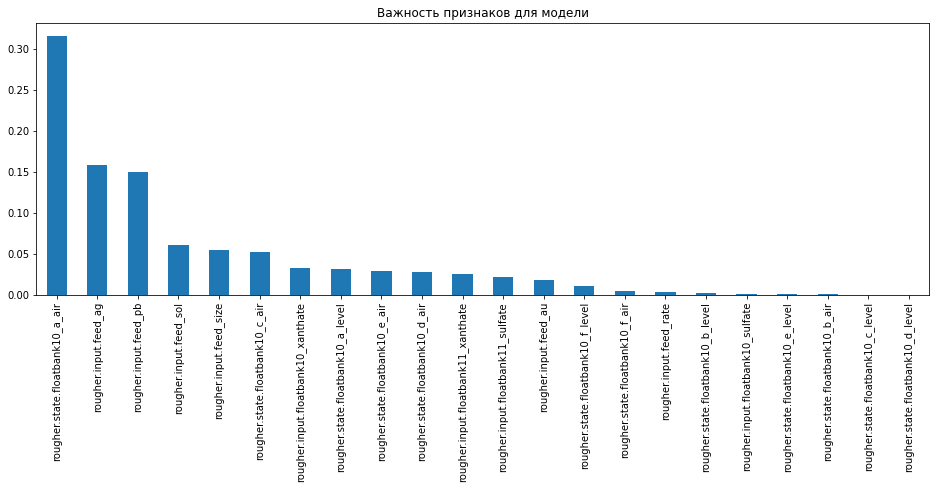

Этап финального концентрата:
Fitting 5 folds for each of 27 candidates, totalling 135 fits

Модель "дерево решений"
Лучшее sMAPE: 9.271961149504197
Лучшие гиперпараметры:
regressor__max_depth            2
regressor__min_samples_leaf     1
regressor__min_samples_split    2
dtype: int64
    


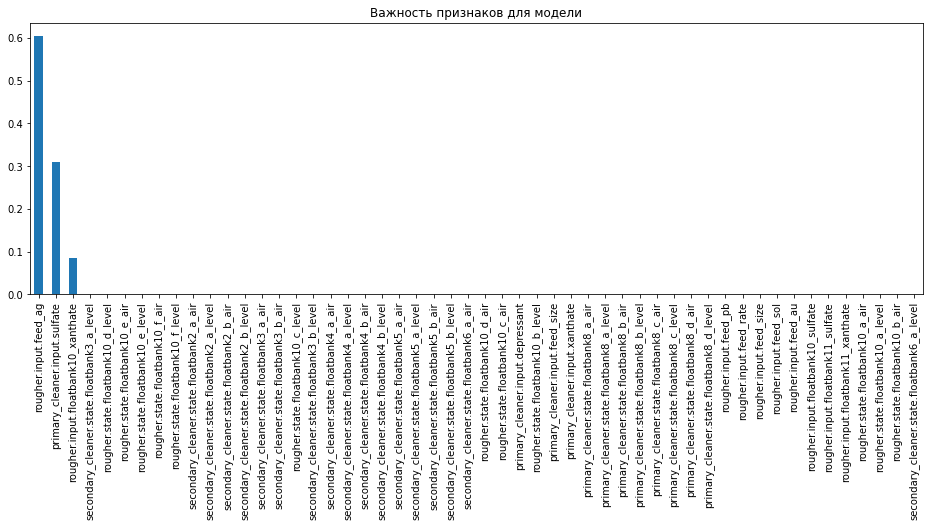

In [30]:
print('Этап чернового концентрата:')
mod_dtr_gs_r, smape_dtr_gs_r, param_dtr_gs_r = dtr_gscv(features_train_rougher, target_train_rougher)
# построение графика важности признаков для модели
pd.Series(mod_dtr_gs_r.best_estimator_.named_steps['regressor'].feature_importances_, features_train_rougher.columns
         ).sort_values(ascending=False).plot(kind='bar', figsize=(16,5), title='Важность признаков для модели')
plt.show()

print('Этап финального концентрата:')
mod_dtr_gs_f, smape_dtr_gs_f, param_dtr_gs_f = dtr_gscv(features_train_final, target_train_final)
# построение графика важности признаков для модели
pd.Series(mod_dtr_gs_f.best_estimator_.named_steps['regressor'].feature_importances_, features_train_final.columns
         ).sort_values(ascending=False).plot(kind='bar', figsize=(16,5), title='Важность признаков для модели')
plt.show()

#### 3.3.4. <a id='toc3_3_4_'></a>[Модель случайный лес (RandomForestRegressor)](#toc0_)

У данной модели большое количество гиперпараметров, которые могут изменяться в большом диапазоне значений, поэтому их подбор проведем в два этапа:
1. Общая оценка гиперпараметров с помощью случайного поиска в широком диапазоне с помощью `RandomizedSearchCV`.
2. Анализ результатов случайного поиска `RandomizedSearchCV` и подбор параметров по заданной решетке более конкретных значений с помощью `GridSearchCV`.

In [31]:
# функция подбора гиперпараметров для 'RandomForestRegressor' с помощью 'RandomizedSearchCV'
# на входе выборки с параметрами и целевым параметром
# на выходе модель, лучшее sMAPE и набор лучших гиперпараметров в виде Series
def rfr_rscv(features, target):
    # создание пайплайн
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', RandomForestRegressor(random_state=RST))
        ])
    # определение параметров и их диапазона для подбора
    param_distr = [{
        'regressor__n_estimators': [int(x) for x in np.linspace(start = 10, stop = 300, num = 20)],
        'regressor__max_depth': [int(x) for x in np.linspace(start = 1, stop = 15, num = 5)],
        'regressor__min_samples_leaf': [int(x) for x in np.linspace(start = 1, stop = 15, num = 5)],
        'regressor__min_samples_split': [int(x) for x in np.linspace(start = 2, stop = 15, num = 5)],
        'regressor__max_features': ['log2', 'sqrt', 1]
        }]
    # определение пользовательской метрики sMAPE на базе функции 'smape_rasch'
    custom_scorer = make_scorer(smape_rasch, greater_is_better=False)
    # подбор гиперпараметров с использованием кросс-валидации
    rfr_rs = RandomizedSearchCV(pipe, param_distributions=param_distr, n_iter = 100, scoring=custom_scorer, cv=3, 
                                verbose=1, n_jobs=-1, random_state=RST)
    rfr_rs.fit(features, target)
    smape_best = -rfr_rs.best_score_
    param_best = pd.Series(rfr_rs.best_params_)
    # вывод результатов
    print(f'''
Модель "случайный лес"
Лучшее sMAPE: {smape_best}
Лучшие гиперпараметры:
{param_best}
    ''')
    return rfr_rs, smape_best, param_best

Этап чернового концентрата:
Fitting 3 folds for each of 100 candidates, totalling 300 fits

Модель "случайный лес"
Лучшее sMAPE: 7.522087949533346
Лучшие гиперпараметры:
regressor__n_estimators           10
regressor__min_samples_split      15
regressor__min_samples_leaf       15
regressor__max_features         log2
regressor__max_depth              11
dtype: object
    


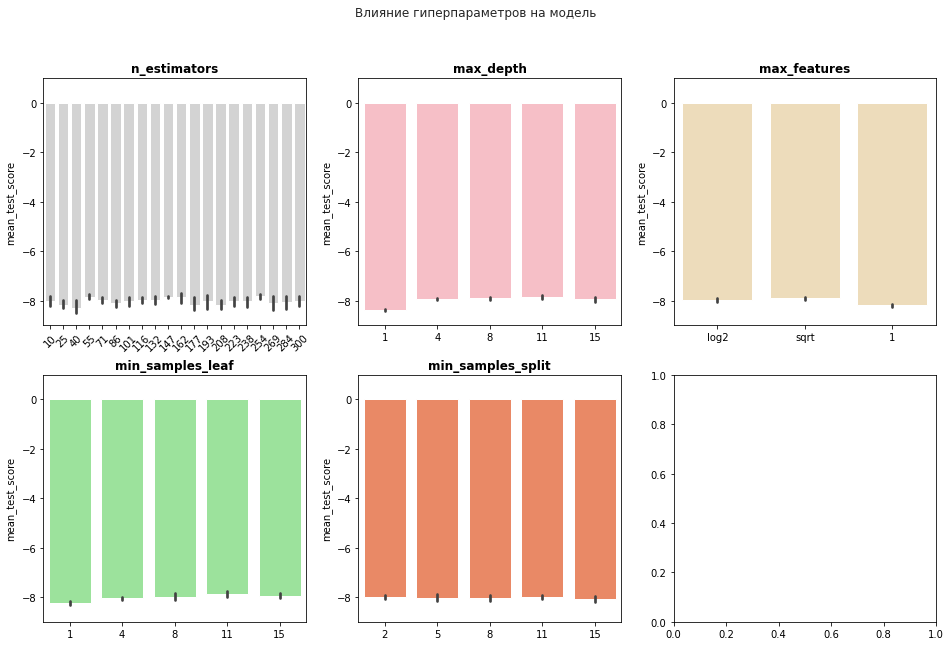

In [32]:
# подбор гиперпараметров для 'RandomForestRegressor' с помощью 'RandomizedSearchCV'
print('Этап чернового концентрата:')
mod_rfr_rs_r, smape_rfr_rs_r, param_rfr_rs_r = rfr_rscv(features_train_rougher, target_train_rougher)

# построение графиков влияния гиперпараметров на модель
res_rs = pd.DataFrame(mod_rfr_rs_r.cv_results_).sort_values(by='rank_test_score')
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
sns.set_style("whitegrid")
fig.suptitle('Влияние гиперпараметров на модель')
sns.barplot(x='param_regressor__n_estimators', y='mean_test_score', data=res_rs, ax=axes[0,0], color='lightgrey'
           ).set_xlabel('')
axes[0,0].set_ylim([-9,1])
axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=45)
axes[0,0].set_title(label = 'n_estimators', weight='bold')
sns.barplot(x='param_regressor__max_depth', y='mean_test_score', data=res_rs, ax=axes[0,1], color='lightpink'
           ).set_xlabel('')
axes[0,1].set_ylim([-9,1])
axes[0,1].set_title(label = 'max_depth', weight='bold')
sns.barplot(x='param_regressor__max_features', y='mean_test_score', data=res_rs, ax=axes[0,2], color='wheat'
           ).set_xlabel('')
axes[0,2].set_ylim([-9,1])
axes[0,2].set_title(label = 'max_features', weight='bold')
sns.barplot(x='param_regressor__min_samples_leaf', y='mean_test_score', data=res_rs, ax=axes[1,0], color='lightgreen'
           ).set_xlabel('')
axes[1,0].set_ylim([-9,1])
axes[1,0].set_title(label = 'min_samples_leaf', weight='bold')
sns.barplot(x='param_regressor__min_samples_split', y='mean_test_score', data=res_rs, ax=axes[1,1], color='coral'
           ).set_xlabel('')
axes[1,1].set_ylim([-9,1])
axes[1,1].set_title(label = 'min_samples_split', weight='bold')
plt.show()

На графиках показано влияние гиперпараметров на минимизацию пользовательской метрики `sMAPE`.  
Можно выделить следующие диапазоны гиперпараметров для дальнейшего уточнения с помощью `GridSearchCV`:
- `n_estimators` - лучшие значения гиперпараметра в районе 55 и 162;
- `max_depth` - лучшие значения гиперпараметра в районе 11;
- `max_features` - лучшее значения гиперпараметра 'sqrt';
- `min_samples_leaf` - лучшие значения гиперпараметра в районе 11 ;
- `min_samples_split` - лучшие значения гиперпараметра в районе 2 и 11.

Далее отработаем эти диапазоны с помощью `GridSearchCV`.

In [36]:
# функция подбора гиперпараметров для 'RandomForestRegressor' с помощью 'GridSearchCV'
# на входе выборки с параметрами и целевым параметром, диапазоны гиперпараметров
# на выходе модель, лучшее sMAPE и набор лучших гиперпараметров в виде Series
def rfr_gscv(features, target, n_estimators, max_depth, max_features, min_samples_leaf, min_samples_split):
    # создание пайплайн
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', RandomForestRegressor(random_state=RST))
        ])
    # определение параметров и их диапазона для подбора
    param_grid = [{
        'regressor__n_estimators': n_estimators,
        'regressor__max_depth': max_depth,
        'regressor__max_features': max_features,
        'regressor__min_samples_leaf': min_samples_leaf,
        'regressor__min_samples_split': min_samples_split
        }]
    # определение пользовательской метрики sMAPE на базе функции 'smape_rasch'
    custom_scorer = make_scorer(smape_rasch, greater_is_better=False)
    # подбор гиперпараметров с использованием кросс-валидации
    rfr_gs = GridSearchCV(pipe, param_grid=param_grid, scoring=custom_scorer, cv=5, verbose=1, n_jobs=-1)
    rfr_gs.fit(features, target)
    smape_best = -rfr_gs.best_score_
    param_best = pd.Series(rfr_gs.best_params_)    
    # вывод результатов
    print(f'''
Модель "случайный лес"
Лучшее sMAPE: {smape_best}
Лучшие гиперпараметры:
{param_best}
    ''')
    return rfr_gs, smape_best, param_best

Этап чернового концентрата:
Fitting 5 folds for each of 120 candidates, totalling 600 fits

Модель "случайный лес"
Лучшее sMAPE: 6.383736799949597
Лучшие гиперпараметры:
regressor__max_depth              10
regressor__max_features         sqrt
regressor__min_samples_leaf       11
regressor__min_samples_split       2
regressor__n_estimators           55
dtype: object
    


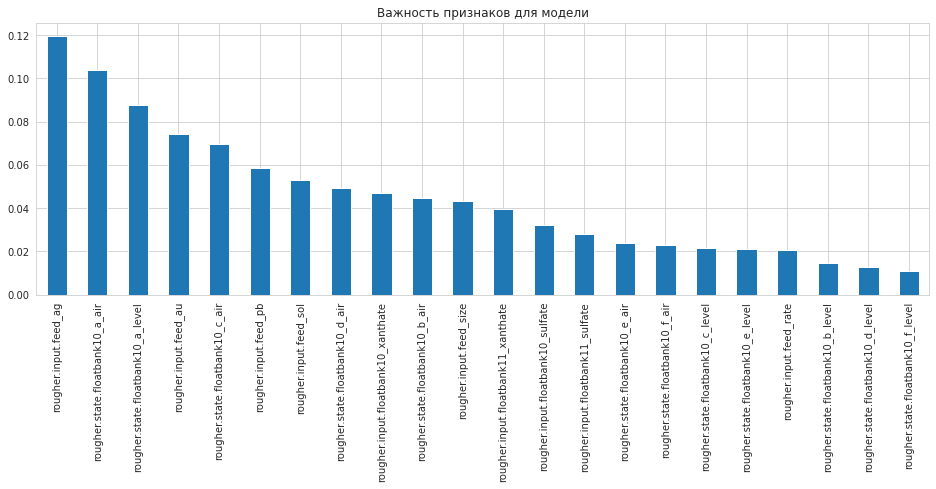

In [37]:
# диапазоны гиперпараметров для подбора в 'RandomForestRegressor'
p_n_estimators = [50, 55, 60, 155, 160, 165]
p_max_depth = range(10, 12)
p_max_features = ['sqrt']
p_min_samples_leaf = range (10, 12)
p_min_samples_split = [2, 3, 10, 11, 12]

# подбор гиперпараметров для 'RandomForestRegressor' с помощью 'GridSearchCV'
print('Этап чернового концентрата:')
mod_rfr_gs_r, smape_rfr_gs_r, param_rfr_gs_r = rfr_gscv(features_train_rougher, target_train_rougher,
                                p_n_estimators, p_max_depth, p_max_features, p_min_samples_leaf, p_min_samples_split)
# построение графика важности признаков для модели
pd.Series(mod_rfr_gs_r.best_estimator_.named_steps['regressor'].feature_importances_, features_train_rougher.columns
         ).sort_values(ascending=False).plot(kind='bar', figsize=(16,5), title='Важность признаков для модели')
plt.show()

Аналогично в два этапа осуществим подбор гиперпараметров для этапа финального концентрата.

Этап финального концентрата:
Fitting 3 folds for each of 100 candidates, totalling 300 fits

Модель "случайный лес"
Лучшее sMAPE: 10.000526402539114
Лучшие гиперпараметры:
regressor__n_estimators          147
regressor__min_samples_split       5
regressor__min_samples_leaf        1
regressor__max_features         sqrt
regressor__max_depth               4
dtype: object
    


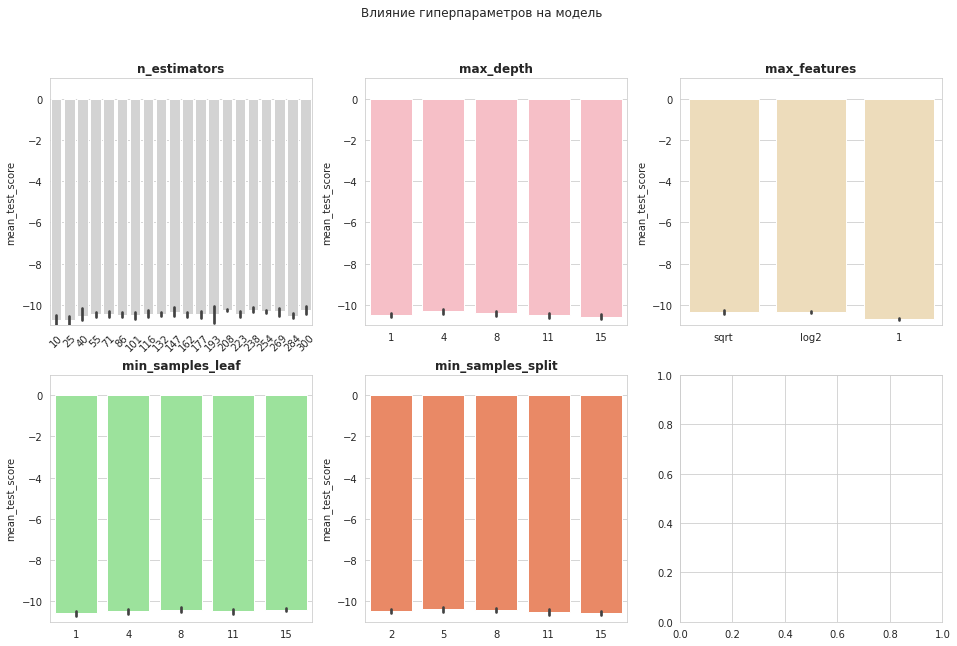

In [38]:
# подбор гиперпараметров для 'RandomForestRegressor' с помощью 'RandomizedSearchCV'
print('Этап финального концентрата:')
mod_rfr_rs_f, smape_rfr_rs_f, param_rfr_rs_f = rfr_rscv(features_train_final, target_train_final)

# построение графиков влияния гиперпараметров на модель
res_rs = pd.DataFrame(mod_rfr_rs_f.cv_results_).sort_values(by='rank_test_score')
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
sns.set_style("whitegrid")
fig.suptitle('Влияние гиперпараметров на модель')
sns.barplot(x='param_regressor__n_estimators', y='mean_test_score', data=res_rs, ax=axes[0,0], color='lightgrey'
           ).set_xlabel('')
axes[0,0].set_ylim([-11,1])
axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=45)
axes[0,0].set_title(label = 'n_estimators', weight='bold')
sns.barplot(x='param_regressor__max_depth', y='mean_test_score', data=res_rs, ax=axes[0,1], color='lightpink'
           ).set_xlabel('')
axes[0,1].set_ylim([-11,1])
axes[0,1].set_title(label = 'max_depth', weight='bold')
sns.barplot(x='param_regressor__max_features', y='mean_test_score', data=res_rs, ax=axes[0,2], color='wheat'
           ).set_xlabel('')
axes[0,2].set_ylim([-11,1])
axes[0,2].set_title(label = 'max_features', weight='bold')
sns.barplot(x='param_regressor__min_samples_leaf', y='mean_test_score', data=res_rs, ax=axes[1,0], color='lightgreen'
           ).set_xlabel('')
axes[1,0].set_ylim([-11,1])
axes[1,0].set_title(label = 'min_samples_leaf', weight='bold')
sns.barplot(x='param_regressor__min_samples_split', y='mean_test_score', data=res_rs, ax=axes[1,1], color='coral'
           ).set_xlabel('')
axes[1,1].set_ylim([-11,1])
axes[1,1].set_title(label = 'min_samples_split', weight='bold')
plt.show()

На графиках можно выделить следующие диапазоны гиперпараметров для дальнейшего уточнения с помощью `GridSearchCV`:
- `n_estimators` - лучшие значения гиперпараметра в районе 147 и 208;
- `max_depth` - лучшие значения гиперпараметра в районе 4;
- `max_features` - лучшее значения гиперпараметра 'log2';
- `min_samples_leaf` - лучшие значения гиперпараметра в районе 8;
- `min_samples_split` - лучшие значения гиперпараметра в районе 5.

Далее отработаем эти диапазоны с помощью `GridSearchCV`.

Этап финального концентрата:
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Модель "случайный лес"
Лучшее sMAPE: 9.068759069084233
Лучшие гиперпараметры:
regressor__max_depth               4
regressor__max_features         log2
regressor__min_samples_leaf        7
regressor__min_samples_split       4
regressor__n_estimators          205
dtype: object
    


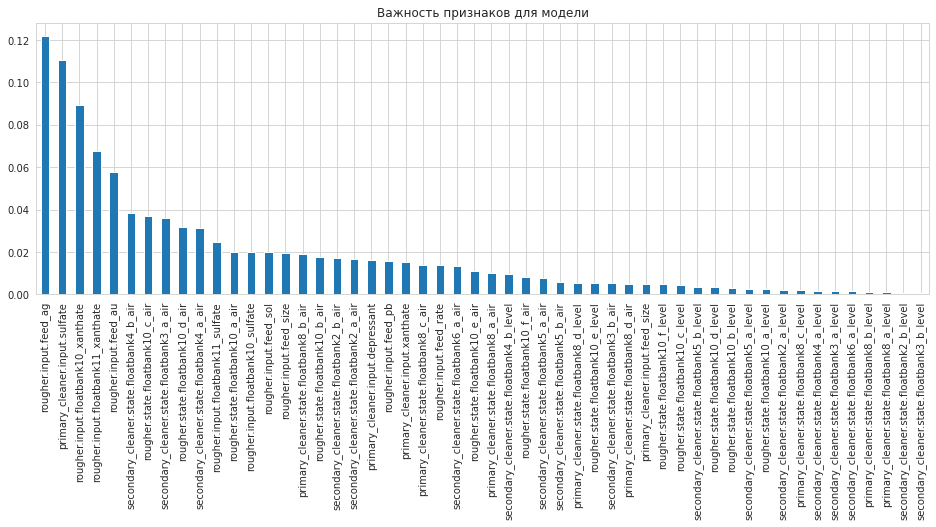

In [39]:
# диапазоны гиперпараметров для подбора в 'RandomForestRegressor'
p_n_estimators = [140, 145, 150, 205, 210, 215]
p_max_depth = range(3, 5)
p_max_features = ['log2']
p_min_samples_leaf = range (7, 9)
p_min_samples_split = range (4, 6)

# подбор гиперпараметров для 'RandomForestRegressor' с помощью 'GridSearchCV'
print('Этап финального концентрата:')
mod_rfr_gs_f, smape_rfr_gs_f, param_rfr_gs_f = rfr_gscv(features_train_final, target_train_final,
                                p_n_estimators, p_max_depth, p_max_features, p_min_samples_leaf, p_min_samples_split)
# построение графика важности признаков для модели
pd.Series(mod_rfr_gs_f.best_estimator_.named_steps['regressor'].feature_importances_, features_train_final.columns
         ).sort_values(ascending=False).plot(kind='bar', figsize=(16,5), title='Важность признаков для модели')
plt.show()

### 3.4. <a id='toc3_4_'></a>[Проверка на тестовой выборке](#toc0_)

Сведем sMAPE по всем моделям на обоих этапах в общую таблицу, чтобы выбрать лучшую модель.

In [40]:
models_smape = pd.DataFrame(data=[
        [smape_lg_cv_r, smape_lg_cv_f],
        [smape_rid_gs_r, smape_rid_gs_f],
        [smape_dtr_gs_r, smape_dtr_gs_f],
        [smape_rfr_gs_r, smape_rfr_gs_f]],
         index=['линейная регрессия (LinearRegression)','линейная регрессия с L2 регуляризацией (Ridge)',
                'дерево решений (DecisionTreeRegressor)','случайный лес (RandomForestRegressor)'],
         columns=[['sMAPE', 'sMAPE'],['на этапе чернового концентрата', 'на этапе финального концентрата']])
display(models_smape)

sMAPE  \
                                               на этапе чернового концентрата   
линейная регрессия (LinearRegression)                                6.673976   
линейная регрессия с L2 регуляризацией (Ridge)                       6.532723   
дерево решений (DecisionTreeRegressor)                               7.090231   
случайный лес (RandomForestRegressor)                                6.383737   

                                                                                
                                               на этапе финального концентрата  
линейная регрессия (LinearRegression)                                11.019680  
линейная регрессия с L2 регуляризацией (Ridge)                       10.638463  
дерево решений (DecisionTreeRegressor)                                9.271961  
случайный лес (RandomForestRegressor)                                 9.068759

Лучшие (наименьшие) значения sMAPE на этапах чернового и финального концентратов дает модель случайный лес (RandomForestRegressor). Проверим результаты работы этой модели на тестовой выборке.

In [41]:
predict_rougher = pd.Series(mod_rfr_gs_r.predict(features_test_rougher))
predict_final = pd.Series(mod_rfr_gs_f.predict(features_test_final))

print(f'''
На тестовой выборке
sMAPE на этапе чернового концентрата: {smape_rasch(target_test_rougher, predict_rougher)}.
sMAPE на этапе финального концентрата: {smape_rasch(target_test_final, predict_final)}.
Итоговое sMAPE: {smape_total(target_test_rougher, predict_rougher, target_test_final, predict_final)}.
''')


На тестовой выборке
sMAPE на этапе чернового концентрата: 7.693461779689222.
sMAPE на этапе финального концентрата: 9.063662305314008.
Итоговое sMAPE: 8.72111217390781.



Выполним проверку на адекватность сравнив результаты с результатами дамми-модели с медианными значениями.

In [42]:
# создание, обучение и получение предсказаний дамми-модели с медианными значениями для чернового концентрата
dummy_r = DummyRegressor(strategy='median').fit(features_train_rougher, target_train_rougher)
predict_dummy_r = pd.Series(dummy_r.predict(features_test_rougher))

# создание, обучение и получение предсказаний дамми-модели с медианными значениями для финального концентрата
dummy_f = DummyRegressor(strategy='median').fit(features_train_final, target_train_final)
predict_dummy_f = pd.Series(dummy_f.predict(features_test_final))

# расчет итогового sMAPE для дамми-модели
print('Итоговое sMAPE для дамми-модели:', smape_total(target_test_rougher, predict_dummy_r, target_test_final, predict_dummy_f))

Итоговое sMAPE для дамми-модели: 9.45026814717098


Итоговый sMAPE у дамми-модели получился хуже (больше) чем у нашей модели случайный лес `RandomForestRegressor`, значит нашу модель можно считать адекватной.

### 3.5. <a id='toc3_5_'></a>[Вывод по результатам раздела 3](#toc0_)

Анализируя все рассмотренные модели можно сделать следующие выводы:
- Модели класса "деревья" показывают лучшие результаты, чем модели класса "регрессия".
- Внутри класса "регрессия" модель линейной регрессии с L2 регуляризацией (`Ridge`) дает чуть лучшие результаты чем простая линейная регрессия (`LinearRegression`).
- Внутри класса "деревья" модель случайный лес (`RandomForestRegressor`) показывает лучшие результаты по сравнению с моделью дерево решений (`DecisionTreeRegressor`) и в целом является лучшей из всех рассмотренных моделей.

## 4. <a id='toc4_'></a>[Общий вывод](#toc0_)

В исследовании использовались предоставленные Заказчиком исходные данные в объеме около 20 тыс. строк.

Общий обзор данных дал следующую информацию:
- дубликаты отсутствуют;
- типы данных соответствуют содержанию, все признаки количественные (числовые, тип с плавающей запятой);
- в рамках предобработки данных выполнено заполнение пропусков данных;
- сильной корреляции между параметрами не наблюдается, единичные случаи обусловлены особенностями технологического процесса;  
- значения эффективности обогащения чернового и финального концентратов, имеющиеся в составе исходных данных, проверены и совпадают с расчетными значениями этих параметров;
- в тестовой выборке не содержатся параметры продукта на разных стадиях обработки (составляющие основного концентрата и отвальные хвосты), целевые признаки (эффективность обогащения чернового и финального концентратов) и расчётные характеристики.

В результате анализа данных о составе, концентрации и размере гранул веществ на этапах технологического процесса установлено:
- Концентрация основного инградиента - золота (Au) увеличивается с 8% в исходном сырье до 45% в финальном концентрате. Концентрация неосновных инградиентов на этапах процесса практически не меняется. В целом концентрация полезных веществ концентрате по мере прохождения стадий технологического процесса растет и на выходе достигает своего максимума, при этом разброс концентрации уменьшается и на выходе достигает своего минимума.
- В "отвальных хвостах" содержится большая концентрация Sol (солей) и незначительная концентрация металлов. Исключение составляет серебро (Ag), имеющее высокую концентрацию в составе "отвальных хвостов" на выходе первого и второго этапов очистки, что, скорее всего, связано с особенностями технологического процесса.
- Форма графиков и диапазон распределения размеров гранул на входе технологического процесса и на входе первого этапа очистки в обучающей и тестовой выборках большей частью совпадают. Изменение состава тестовой выборки невозможно, так как определено Заказчиком.

Для прогнозирования целевых параметров были обучены и исследованы четыре модели:
- линейная регрессия (`LinearRegression`);
- линейная регрессия с L2 регуляризацией (`Ridge`);
- дерево решений (`DecisionTreeRegressor`);
- случайный лес (`RandomForestRegressor`).

Для оценки моделей использовалась метрика sMAPE - симметричное среднее абсолютное процентное отклонение (меньшее значение лучше).  
Заданием были определены два целевых признака, в связи с этим, оценка sMAPE проводилась в двух местах: на этапе чернового и финального концентратов.

В рамках подготовки выборок для обучения моделей, из них удалены данные не являющиеся признаками. Для исключения утечки данных, из обучающей выборки для моделей на этапе чернового концентрата удалены параметры, которые в рамках технологического процесса возникают на последующих этапах. Для всех моделей в качестве предобработки применялось масштабирование параметров с помощью `StandardScaler`. Подбор гиперпараметров осуществлялся с помощью `GridSearchCV` и `RandomizedSearchCV`. К обучающей выборке применялась кросс-валидация. Для создания сквозного процесса использовался пайплайн (`Pipeline`).

По результатам тестирования модели класса "деревья" показали себя лучше, чем модели класса "регрессия".

Определена лучшая модель - модель случайный лес (`RandomForestRegressor`), её качество проверено на тестовой выборке.

Цель проекта, а именно прохождение этапов подготовки данных и построения модели для производства золота, достигнута. Дополнительно можно обратить внимание, что разность метрик качества дамми (константной) модели и нашей лучшей модели не очень большая. Такое расхождение метрик допустимо в данном проекте.

В рамках дальнейшего улучшения качества моделирования можно рассмотреть следующие направления работы:
- Улучшение качества данных на входе модели машинного обучения: повторно оценить аномалии, пропуски, соответствие законам химии и физики, проверить на правдоподобность.
- Работа с моделями машинного обучения:
   - создание новых признаков для моделей (Features Engineering), в частности ориентируясь и анализируя технологический процесс;
   - подбор моделей машинного обучения и гиперпараметров.
- Анализ параметров производственного процесса (например, температуры сырья, скорости конвейера и т.п.) и измерительных систем. Это поможет разобраться в причинах неточности полученных с производства данных и улучшить их.
- Статистический анализ данных.